# **Étude de faisabilité - Classification automatique des biens de consommation**
___
Cette étude vise à étudier la faisabilité d'un moteur de classification des articles en différentes catégories, basé sur une image et une description, et avec un niveau de précision suffisant,  pour l'automatisation de l'attribution de la catégorie des articles.
___


## 0. MISE EN PLACE

 Nous commençons par mettre en place notre cadre de travail en effectuant les actions suivantes :
 - Importation des librairies et packages Python nécessaires
 - Importation des fonctions utiles implémentées 
 - Chargement du jeu de données

___
### 0.1 Importation des librairies Python nécessaires

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import math
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.image import imread
import time
import random
import operator
import scipy.cluster.hierarchy as shc
import multiprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, FreqDist
from sklearn import (preprocessing,
                     manifold,
                     decomposition)
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from PIL import Image, ImageOps, ImageFilter
import tensorflow as tf
import keras
from keras.preprocessing import image
import cv2 as cv

In [3]:
# Only to be run the first time

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RaissaTomeba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RaissaTomeba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\RaissaTomeba\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

___
### 0.2 Importation des fonctions utiles

Par soucis de clarté (lisibilité) et afin d'assurer un meilleur confort de lecture de ce notebook, les fonctions implémentées pour la manipulation des données et la réalisation des graphiques ont été regroupées dans le fichier project_functions.py.

Ces fonctions sont importées via la ligne de code ci-dessous:

In [5]:
import project_functions as pf

___
### 0.3 Chargement du jeu de données

In [6]:
products = pd.read_csv("../Dataset/Flipkart/flipkart_com-ecommerce_sample_1050.csv", sep=",")

## 1. DESCRIPTION DU JEU DE DONNEES

___
### 1.1 Apperçu des données

In [7]:
products.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

Chaque ligne correspond à une produit, avec son nom et ses caractéristiques associées telle qu'une description, la catégorie du produit, la marque, une image etc...

### 1.2 Structure des données

In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [9]:
pf.describe_dataset({'sample e-commerce':[products, "Produits"]})

Les données se décomposent en 1 fichier(s): 



Nom du fichier  Nb de lignes  Nb de colonnes Description
1  sample e-commerce          1050              15    Produits

Le jeu de données contient 1050 lignes et 15 colonnes.

### 1.3 Données manquantes

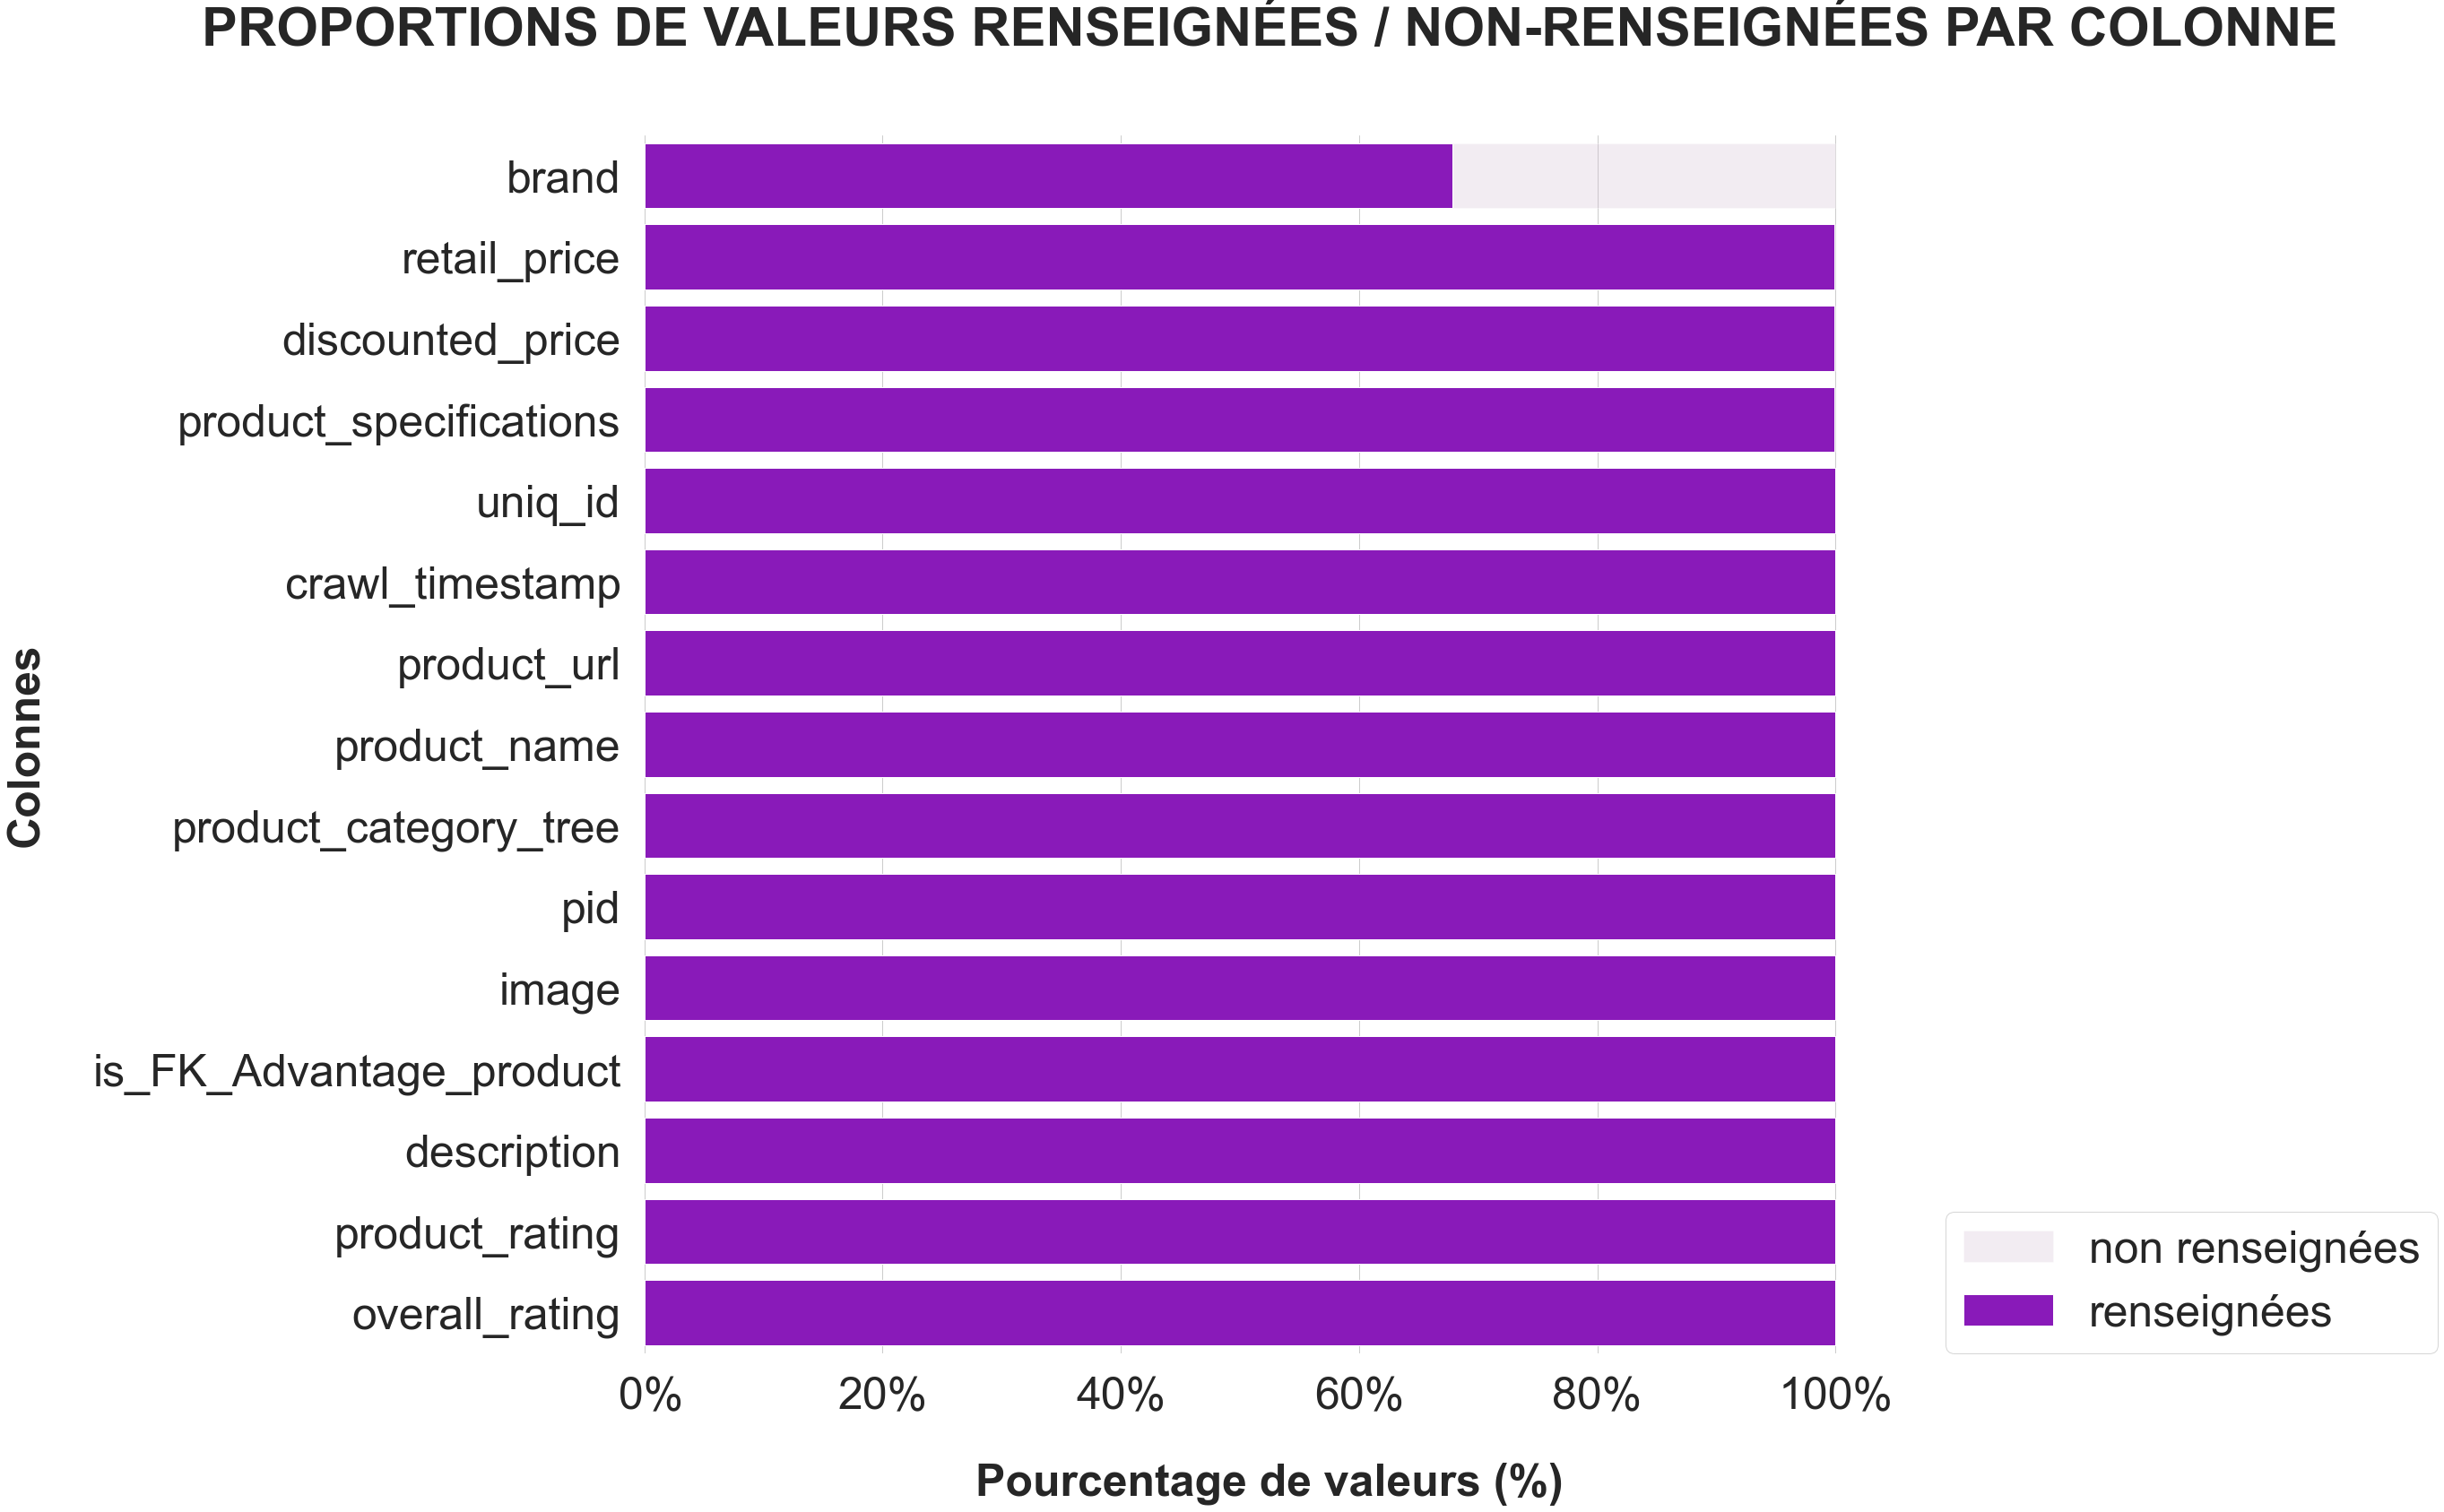

In [10]:
pf.plot_percentage_missing_values_for(products, 25, 25)

- Dans l'ensemble les colonnes sont très bien renseignées (taux de remplissage > 90%), exceptée la colonne "brand"
- La colonne 'brand' contient plus de 30 % de données manquantes

In [11]:
# Les valeurs manquantes pour la variable "brand" sont remplacés par "".
products["brand"].fillna("", inplace=True)

### 1.4 Les catégories produits

Chaque produit est catégorisée par un système d'arbres avec plusieurs niveaux. Le nom de la colonne renseignant les catégories est `product_category_tree`.

In [12]:
# Exemple de la catégorie d'un produit
print(products["product_category_tree"][0])

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


In [13]:
# On récupère la colomne "product_category_tree"
list_categories_0, list_categories_1 = [], []
for txt in products["product_category_tree"] :
    
    list_categories_0.append(txt.split(">>")[0].split("\"")[1].strip()) # split du nom par >> et on récupère la première partie
    list_categories_1.append(txt.split(">>")[1].strip()) # split du nom par >> et on récupère la première partie

# Création d'une nouvelle série catégorie    
products["category_0"] = pd.Series(list_categories_0)
products["category_1"] = pd.Series(list_categories_1)

print("Il y a {} catégories de niveau 0 et {} categories de niveau 1".format(products["category_0"].nunique(), products["category_1"].nunique()))

Il y a 7 catégories de niveau 0 et 63 categories de niveau 1


#### Affichage des catégories de niveau 0

In [14]:
font_title = {"weight": "bold",
              "size": 30}

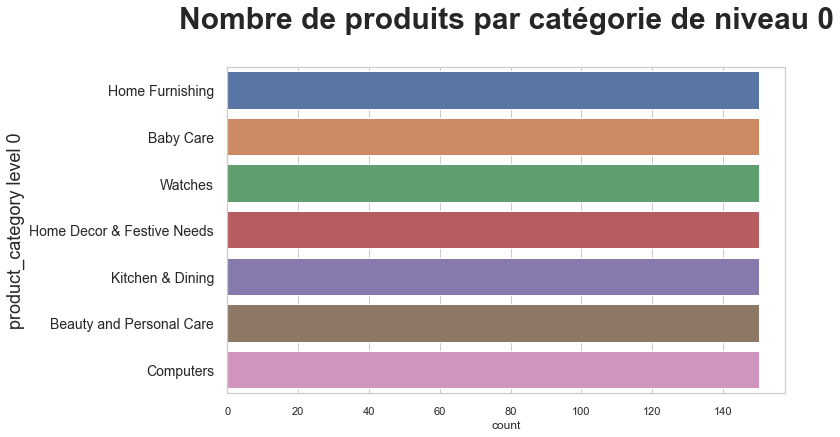

In [15]:
fig = plt.figure(figsize=(10, 6))
sns.countplot(data=products, y="category_0",
             order = products["category_0"].value_counts().index,)
plt.yticks(size=14)
plt.title(f"Nombre de produits par catégorie de niveau 0\n",
          fontdict=font_title)
plt.ylabel("product_category level 0", fontsize=18)
plt.show()

#### Affichage des catégories de niveau 1

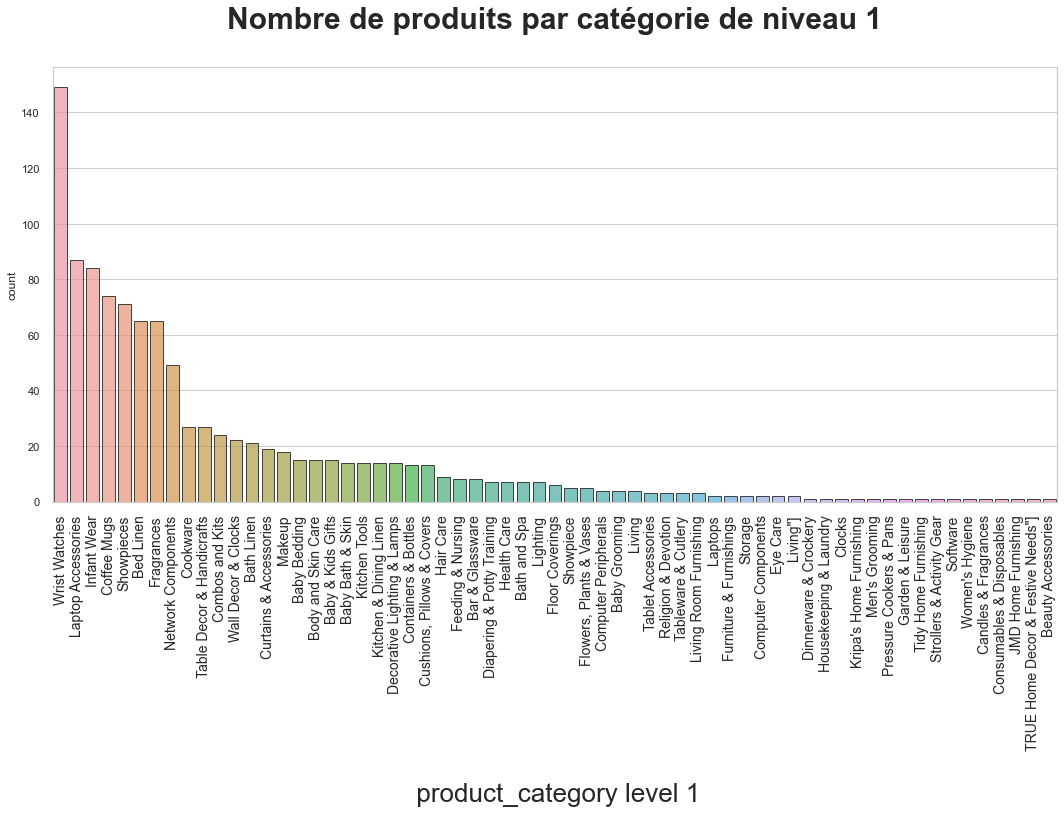

In [16]:
fig = plt.figure(figsize=(18, 8))
sns.countplot(data=products, x="category_1",
              edgecolor="black",
              order = products['category_1'].value_counts().index,
              alpha=0.7)
plt.xticks(rotation=90, size=14)
plt.title(f"Nombre de produits par catégorie de niveau 1\n",
          fontdict=font_title)
plt.xlabel('\n product_category level 1', fontsize=26)
plt.show()

In [17]:
# Les catégories utilisés pour la résolution du problème de segmentation
categories = products["category_0"]

### 1.5 Descriptif des produits

Ci-dessous, vous trouverez un exemple de texte descriptif d'un produit

In [18]:
des = products.loc[products.uniq_id == "3c4ca34c50a5437a1bcc42b72fc1351f"]

print("La catégorie du produit est : {} \n".format(des["category_0"].iloc[0]))

print("La marque du produit est : {} \n".format(des["brand"].iloc[0]))

print("Le nom du produit est : {} \n".format(des["product_name"].iloc[0]))

print("Le descriptif du produit est : \n \n {}".format(des["description"].iloc[0]))

La catégorie du produit est : Kitchen & Dining 

La marque du produit est :  

Le nom du produit est : Printland PMR1902 Ceramic Mug 

Le descriptif du produit est : 
 
 Printland PMR1902 Ceramic Mug (350 ml)
                         Price: Rs. 299
				
			Printland coffee mug is an adorable and a fantastic coffee mug. One can enjoy their morning coffee/tea in this huge mug. It is made of ceramic material. It is a perfect add on to your kitchen wardrobe. It looks very stylish & elegant to serve tea/coffee in this mug during a casual get together at home. It is also a perfect gift to be presented to your loved one.
Printland coffee mug is an adorable and a fantastic coffee mug. One can enjoy their morning coffee/tea in this huge mug. It is made of ceramic material. It is a perfect add on to your kitchen wardrobe. It looks very stylish & elegant to serve tea/coffee in this mug during a casual get together at home. It is also a perfect gift to be presented to your loved one.


### 1.6 Vérification des doublons

In [19]:
print("Existe t-il des doublons dans le jeu de données ? {}".format(len(products)!=products["uniq_id"].nunique()))

Existe t-il des doublons dans le jeu de données ? False


### 1.7 Concaténation des variables textes : "product_name", "description" et "brand"

In [20]:
products_text_data = pd.DataFrame()
products_text_data["uniq_id"] = products["uniq_id"]
products_text_data["category"] = products["category_0"]
products_text_data["description"] = products["product_name"] + " "+ products["brand"] + " " + products["description"]
products_text_data

uniq_id         category  \
0     55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1     7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2     64d5d4a258243731dc7bbb1eef49ad74        Baby Care   
3     d4684dcdc759dd9cdf41504698d737d8  Home Furnishing   
4     6325b6870c54cd47be6ebfbffa620ec7  Home Furnishing   
...                                ...              ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc        Baby Care   
1046  fd6cbcc22efb6b761bd564c28928483c        Baby Care   
1047  5912e037d12774bb73a2048f35a00009        Baby Care   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6        Baby Care   
1049  f2f027ad6a6df617c9f125173da71e44        Baby Care   

                                            description  
0     Elegance Polyester Multicolor Abstract Eyelet ...  
1     Sathiyas Cotton Bath Towel Sathiyas Specificat...  
2     Eurospa Cotton Terry Face Towel Set Eurospa Ke...  
3     SANTOSH ROYAL FASHION Cotton Printed King size...  
4     Jaipur Print Cotton Floral King sized Double B...  
...                                                 ...  
1045  Oren Empower Extra Large Self Adhesive Sticker...  
1046  Wallmantra Large Vinyl Sticker Sticker Wallman...  
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...  
1048  Wallmantra Medium Vinyl Sticker Sticker Wallma...  
1049  Uberlyfe Large Vinyl Sticker Uberlyfe Buy Uber...  

[1050 rows x 3 columns]

### 1.8 Les images

#### Affichage d'exemples d'images par catégorie produit de niveau 0

Home Furnishing


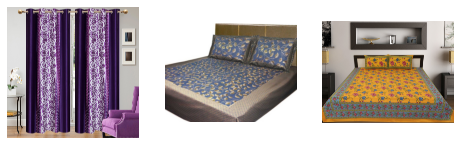

Baby Care


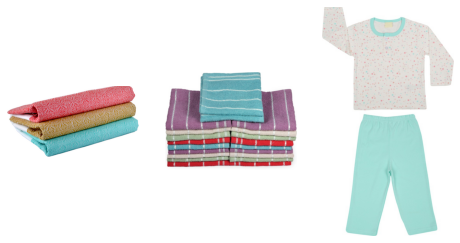

Watches


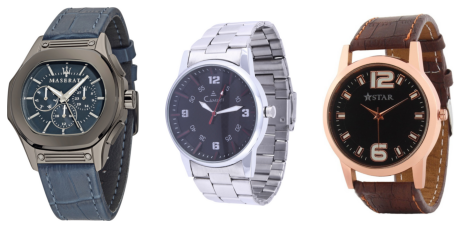

Home Decor & Festive Needs


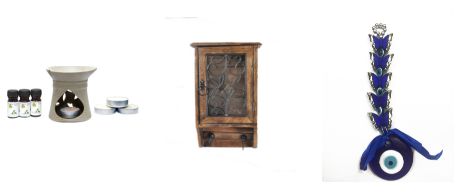

Kitchen & Dining


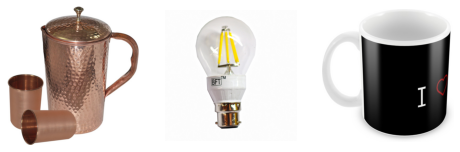

Beauty and Personal Care


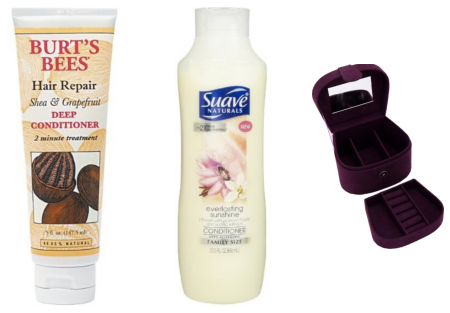

Computers


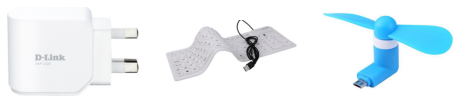

In [21]:
path = "../DataSet/Flipkart/Images/"
for j, categ in enumerate(categories.unique()) :
    bolded_string = "\033[1m" + categ + "\033[0m"
    print(bolded_string)
    # print("-------")
    for i in range(3):
        name_image = products[categories == categ]["image"].iloc[i]
        plt.subplot(130 + 1 + i)
        filename = path + name_image
        img = imread(filename)
        plt.imshow(img)
        plt.axis('off')    
    plt.show()    

___
## 2. NETTOYAGE ET PRÉ-TRAITEMENT

**Textes**

- Suppression des ponctuations
- Tokenization
- Suppression des tokens de taille < 2
- Suppression des stopwords
- Stemming
- Lemmatization
- Conversion des mots en vecteurs de features (BOW, TF-IDF)

### 2.1 Textes

#### 2.1.1 Suppression des ponctuations

In [22]:
products_text_data['removed_punc'] = products_text_data['description'].apply(lambda x: pf.remove_punct(x))
products_text_data.head(3)

uniq_id         category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   

                                         description  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                        removed_punc  
0  Elegance Polyester Multicolor Abstract Eyelet ...  
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...  
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...

#### 2.1.2 Tokenization

In [23]:
products_text_data['tokens'] = products_text_data['removed_punc'].apply(lambda msg : pf.tokenize(msg))
products_text_data.head(3)

uniq_id         category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   

                                         description  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                        removed_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                              tokens  
0  [elegance, polyester, multicolor, abstract, ey...  
1  [sathiyas, cotton, bath, towel, sathiyas, spec...  
2  [eurospa, cotton, terry, face, towel, set, eur...

#### 2.1.3 Suppression des tokens de taille < 2

In [24]:
products_text_data['larger_tokens'] = products_text_data['tokens'].apply(lambda x : pf.remove_small_words(x))
products_text_data.head(3)

uniq_id         category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   

                                         description  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                        removed_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                              tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                       larger_tokens  
0  [elegance, polyester, multicolor, abstract, ey...  
1  [sathiyas, cotton, bath, towel, sathiyas, spec...  
2  [eurospa, cotton, terry, face, towel, set, eur...

#### 2.1.4 Suppression des stopwords

In [25]:
products_text_data['clean_tokens'] = products_text_data['larger_tokens'].apply(lambda x : pf.remove_stopwords(x))
products_text_data.head(3)

uniq_id         category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   

                                         description  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                        removed_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                              tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                       larger_tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                        clean_tokens  
0  [elegance, polyester, multicolor, abstract, ey...  
1  [sathiyas, cotton, bath, towel, sathiyas, spec...  
2  [eurospa, cotton, terry, face, towel, set, eur...

#### 2.1.5 Stemming

In [26]:
products_text_data['stem_words'] = products_text_data['clean_tokens'].apply(lambda wrd: pf.stemming(wrd))
products_text_data.head(3)

uniq_id         category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   

                                         description  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                        removed_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                              tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                       larger_tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                        clean_tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                          stem_words  
0  [eleg, polyest, multicolor, abstract, eyelet, ...  
1  [sathiya, cotton, bath, towel, sathiya, specif...  
2  [eurospa, cotton, terri, face, towel, set, eur...

#### 2.1.6 Lemmatization

In [27]:
products_text_data['lemma_words'] = products_text_data['clean_tokens'].apply(lambda x : pf.lemmatize(x))
products_text_data.head(3)

uniq_id         category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   

                                         description  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                        removed_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                              tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                       larger_tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                        clean_tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                          stem_words  \
0  [eleg, polyest, multicolor, abstract, eyelet, ...   
1  [sathiya, cotton, bath, towel, sathiya, specif...   
2  [eurospa, cotton, terri, face, towel, set, eur...   

                                         lemma_words  
0  [elegance, polyester, multicolor, abstract, ey...  
1  [sathiyas, cotton, bath, towel, sathiyas, spec...  
2  [eurospa, cotton, terry, face, towel, set, eur...

In [28]:
products_text_data['clean_text'] = products_text_data['lemma_words'].apply(lambda x : pf.return_sentences(x))
products_text_data.head(3)

uniq_id         category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   

                                         description  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                        removed_punc  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Sathiyas Specificat...   
2  Eurospa Cotton Terry Face Towel Set Eurospa Ke...   

                                              tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                       larger_tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                        clean_tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                          stem_words  \
0  [eleg, polyest, multicolor, abstract, eyelet, ...   
1  [sathiya, cotton, bath, towel, sathiya, specif...   
2  [eurospa, cotton, terri, face, towel, set, eur...   

                                         lemma_words  \
0  [elegance, polyester, multicolor, abstract, ey...   
1  [sathiyas, cotton, bath, towel, sathiyas, spec...   
2  [eurospa, cotton, terry, face, towel, set, eur...   

                                          clean_text  
0  elegance polyester multicolor abstract eyelet ...  
1  sathiyas cotton bath towel sathiyas specificat...  
2  eurospa cotton terry face towel set eurospa ke...

#### Texte illustratif avant et après prétraitement

In [29]:
des = products_text_data.loc[products_text_data.uniq_id == "3c4ca34c50a5437a1bcc42b72fc1351f"]
print("Le descriptif avant prétraitement est : \n \n {}".format(des["description"].iloc[0])) 

Le descriptif avant prétraitement est : 
 
 Printland PMR1902 Ceramic Mug  Printland PMR1902 Ceramic Mug (350 ml)
                         Price: Rs. 299
				
			Printland coffee mug is an adorable and a fantastic coffee mug. One can enjoy their morning coffee/tea in this huge mug. It is made of ceramic material. It is a perfect add on to your kitchen wardrobe. It looks very stylish & elegant to serve tea/coffee in this mug during a casual get together at home. It is also a perfect gift to be presented to your loved one.
Printland coffee mug is an adorable and a fantastic coffee mug. One can enjoy their morning coffee/tea in this huge mug. It is made of ceramic material. It is a perfect add on to your kitchen wardrobe. It looks very stylish & elegant to serve tea/coffee in this mug during a casual get together at home. It is also a perfect gift to be presented to your loved one.


In [30]:
print("Le descriptif après prétraitement est : \n \n {}".format(des["clean_text"].iloc[0])) 

Le descriptif après prétraitement est : 
 
 printland pmr1902 ceramic mug printland pmr1902 ceramic mug 350 ml price r 299 printland coffee mug adorable fantastic coffee mug one enjoy morning coffeetea huge mug made ceramic material perfect add kitchen wardrobe look stylish elegant serve teacoffee mug casual get together home also perfect gift presented loved one printland coffee mug adorable fantastic coffee mug one enjoy morning coffeetea huge mug made ceramic material perfect add kitchen wardrobe look stylish elegant serve teacoffee mug casual get together home also perfect gift presented loved one


#### Affichage des Top 10 mots les plus fréquents pour chaque catégorie produit de niveau 0

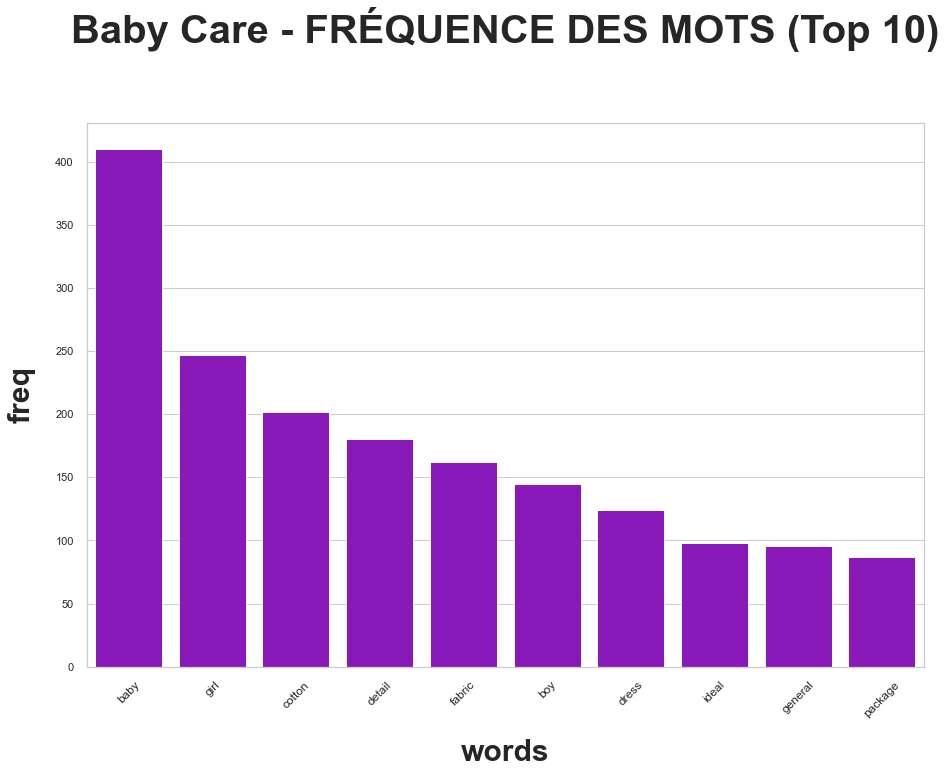

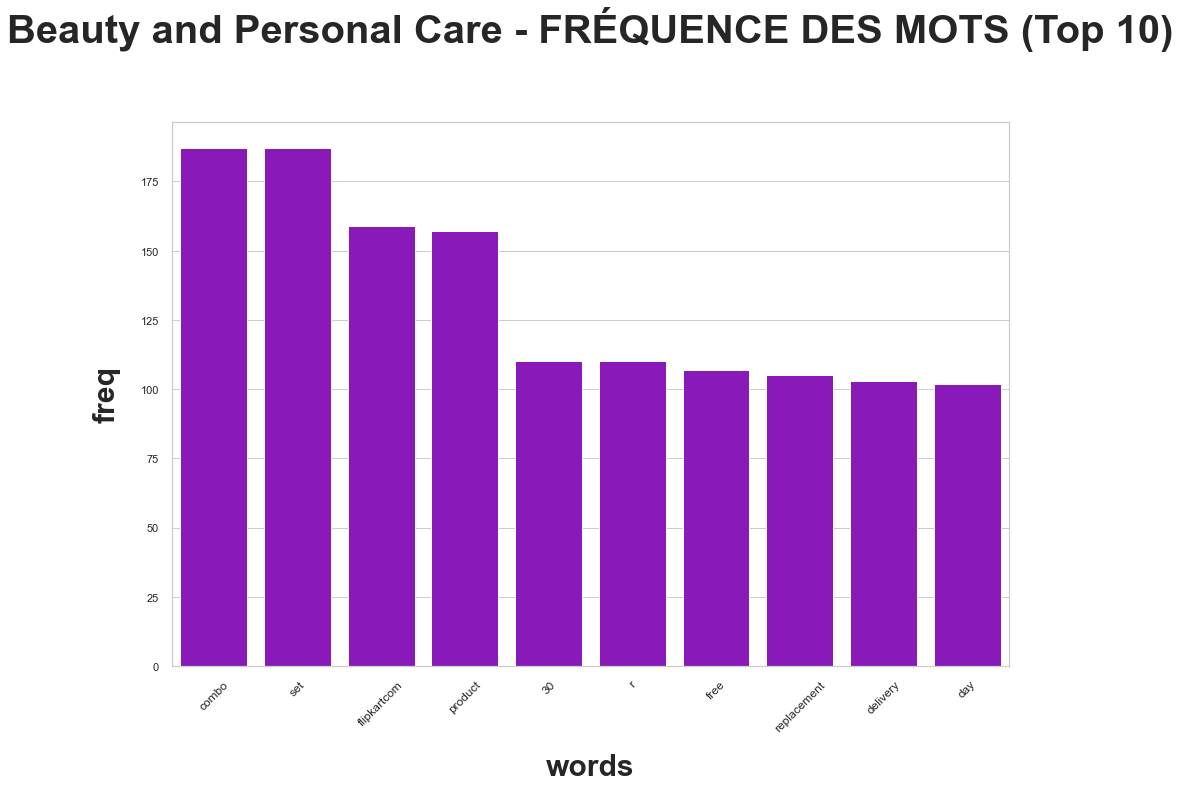

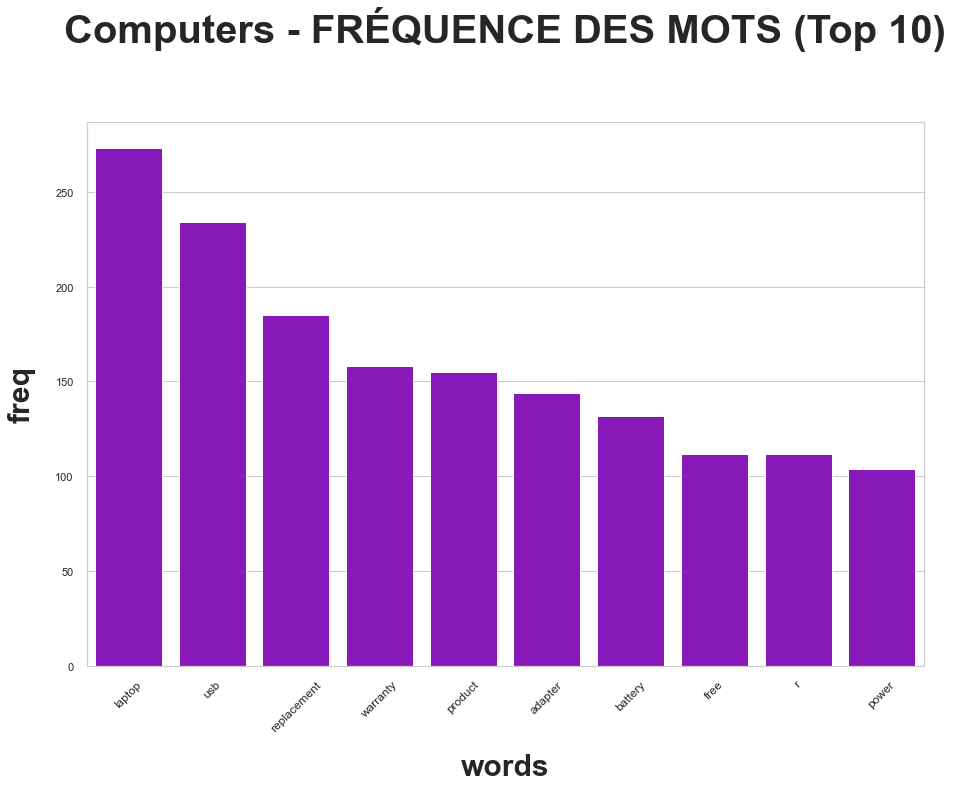

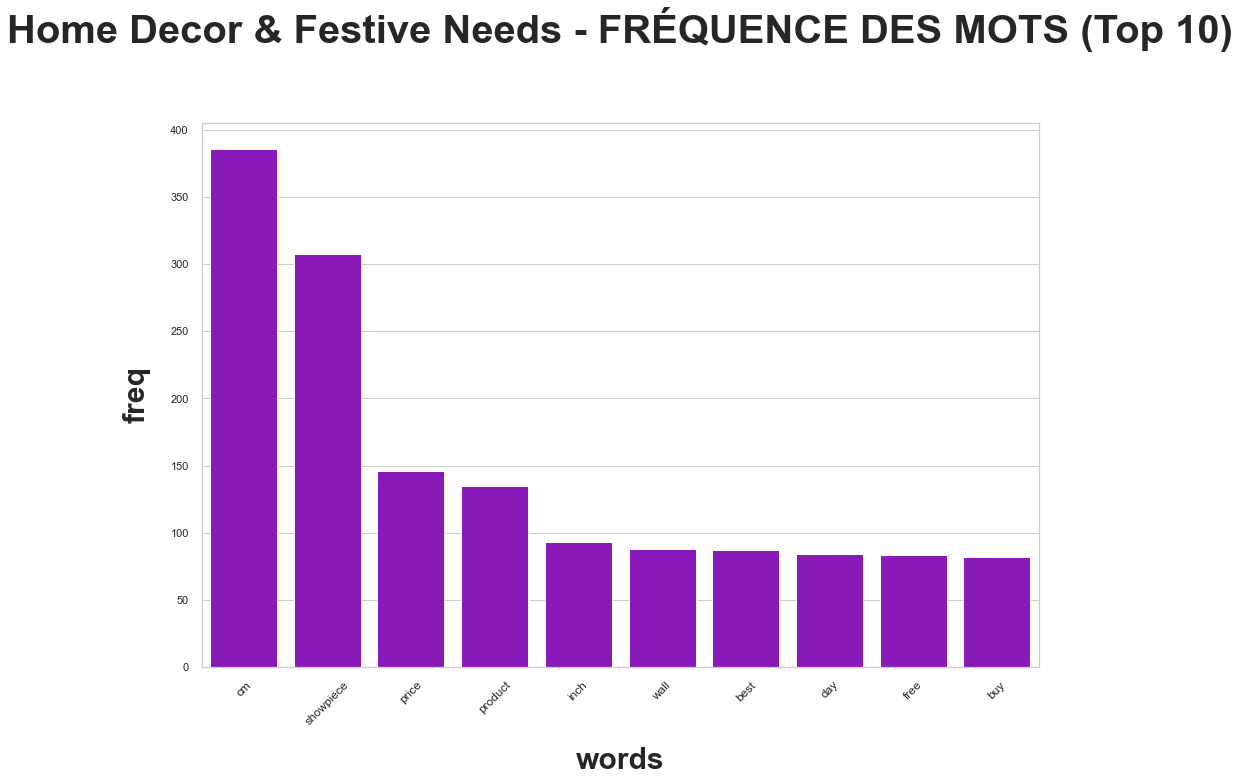

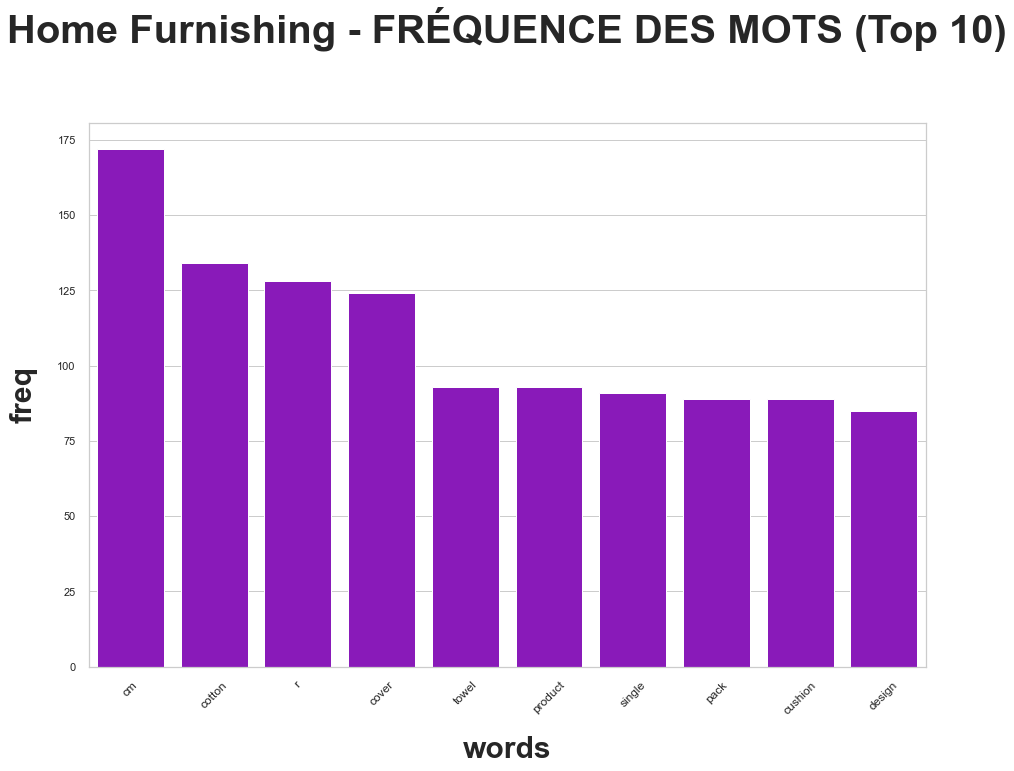

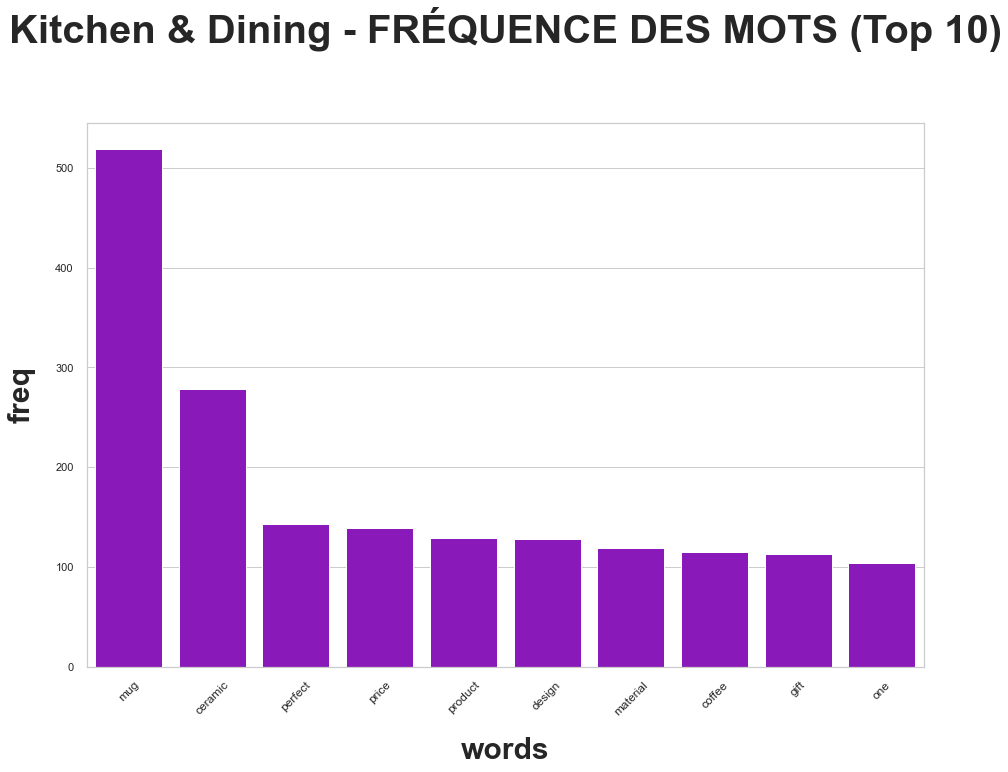

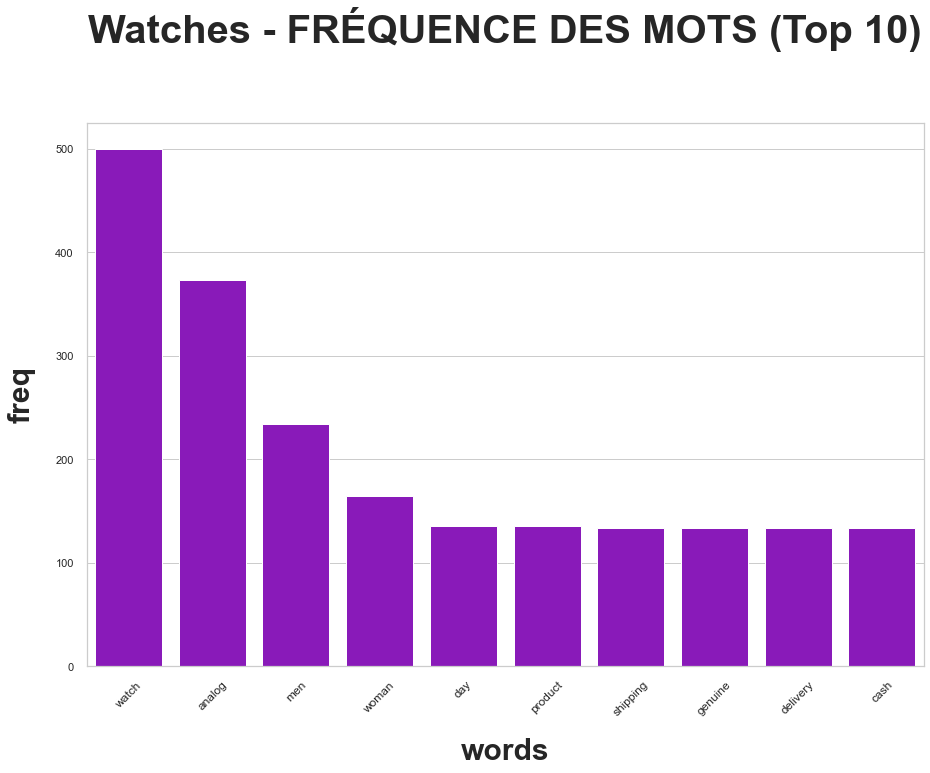

In [31]:
most_freq_dfs = pd.DataFrame()

for cat1, data_df in products_text_data.groupby("category"):
    most_freq_df = pf.get_most_freq(data_df["lemma_words"], 10).reset_index()
    most_freq_df["Category"] = cat1
    most_freq_dfs = pd.concat([most_freq_dfs, most_freq_df])
    pf.plot_freq_dist(most_freq_df, cat1 + " - FRÉQUENCE DES MOTS (Top 10)", 15, 10)

#### Wordclouds par categories produit

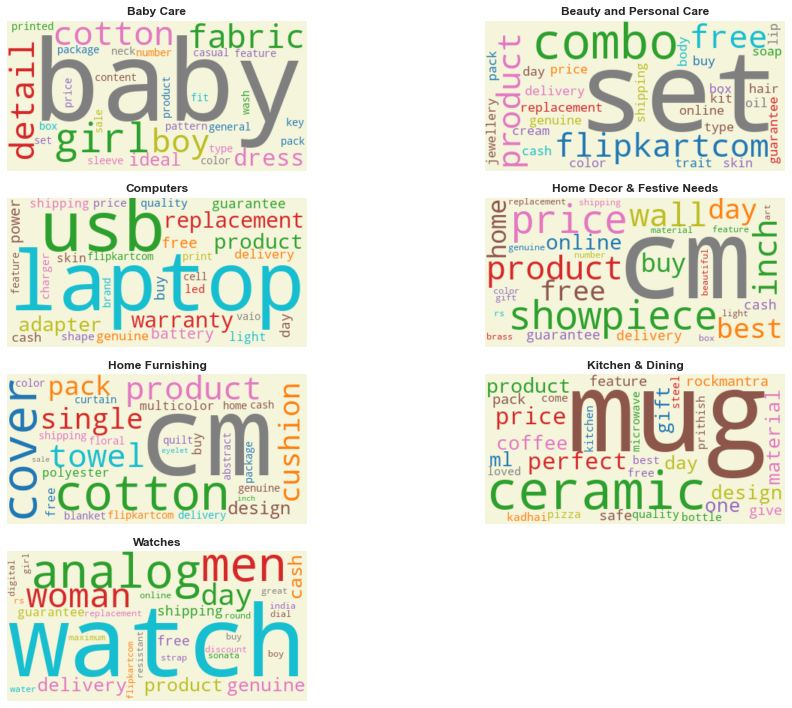

In [32]:
gb = products_text_data.groupby('category')['clean_text']

pf.plot_wordclouds_from_gb(gb, n_top_words=30, n_rows=4, figsize=(15,10),
                        backgnd_color='beige', cmap='tab10', random_state=14)

#### 2.1.7 Conversion des mots en vecteurs de features

Nous allons extraire les features en utilisant les méthodes suivantes:

- Bag of Words (BOW)
- Term Frequency - Inverse Document Frequency (TF-IDF)
- Word2Vec

Nous allons comparer les résultats obtenus avec chacune de ces transformations.

##### 2.1.7.1 Transformation en matrice BOW

In [33]:
bow = CountVectorizer()
bow_vect = bow.fit_transform(products_text_data['clean_text']).toarray()
bow_vect.shape

(1050, 6121)

##### 2.1.7.2 Transformation en matrice TF-IDF

In [34]:
tfidf = TfidfVectorizer()
tfidf_vect = tfidf.fit_transform(products_text_data['clean_text']).toarray()
tfidf_vect.shape

(1050, 6121)

##### 2.1.7.3 Transformation en matrice Word2Vec

In [35]:
from gensim.models import Word2Vec

data_vec =products_text_data['clean_text']
data_token = products_text_data['lemma_words']
cores = multiprocessing.cpu_count()
text_dim=100

In [36]:
# Instanciation du modèle
w2v_model_desc_lem = Word2Vec(min_count=20, window=3, size=text_dim,
                              sample=6e-5, alpha=0.03, min_alpha=0.0007,
                              negative=20, workers=cores-1)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_model_desc_lem.build_vocab(data_token,
                               progress_per=10000)
# Vectorisation
vector_w2v_desc_lem = pf.word2vec_vectorisation(data_vec,
                                                        text_dim,
                                                        w2v_model_desc_lem)

In [37]:
vector_w2v_desc_lem.shape

(1050, 100)

### 2.2 Images

- **PIL** (Pyhton Imaging Library) et **OpenCV** (Open Compute Vision) sont des librairies qui comprennent un ensemble de méthodes permettant de charger, traiter les images (redimensionnement, filtres...). Ces librairies seront utilisées pour le pré-traitement des images.

- Le traitement sera effectué en 5 étapes :
    - Correction de l'exposition (étirement d'histogramme) 
    - Correction du contraste (égalisation d'histogramme)    
    - Réduction du bruit (filtre)
    - Conversion en niveau de gris     
    - Redimensionnement (en 224 * 224)


In [38]:
# Dataframe de travail pour le traitement des images

products_image_data = pd.DataFrame()
products_image_data["image"] = products["image"]
products_image_data['image_loc'] = [path + row for row in products['image']]
products_image_data["category"] = products["category_0"]

products_image_data.head(3)

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                           image_loc         category  
0  ../DataSet/Flipkart/Images/55b85ea15a1536d46b7...  Home Furnishing  
1  ../DataSet/Flipkart/Images/7b72c92c2f6c4026862...        Baby Care  
2  ../DataSet/Flipkart/Images/64d5d4a258243731dc7...        Baby Care

#### 2.2.1 Illustration du pré-traitement sur une image

In [39]:
dim = (224, 224)

<span style='background:Moccasin'>**Chargement de l'image originale**</span>

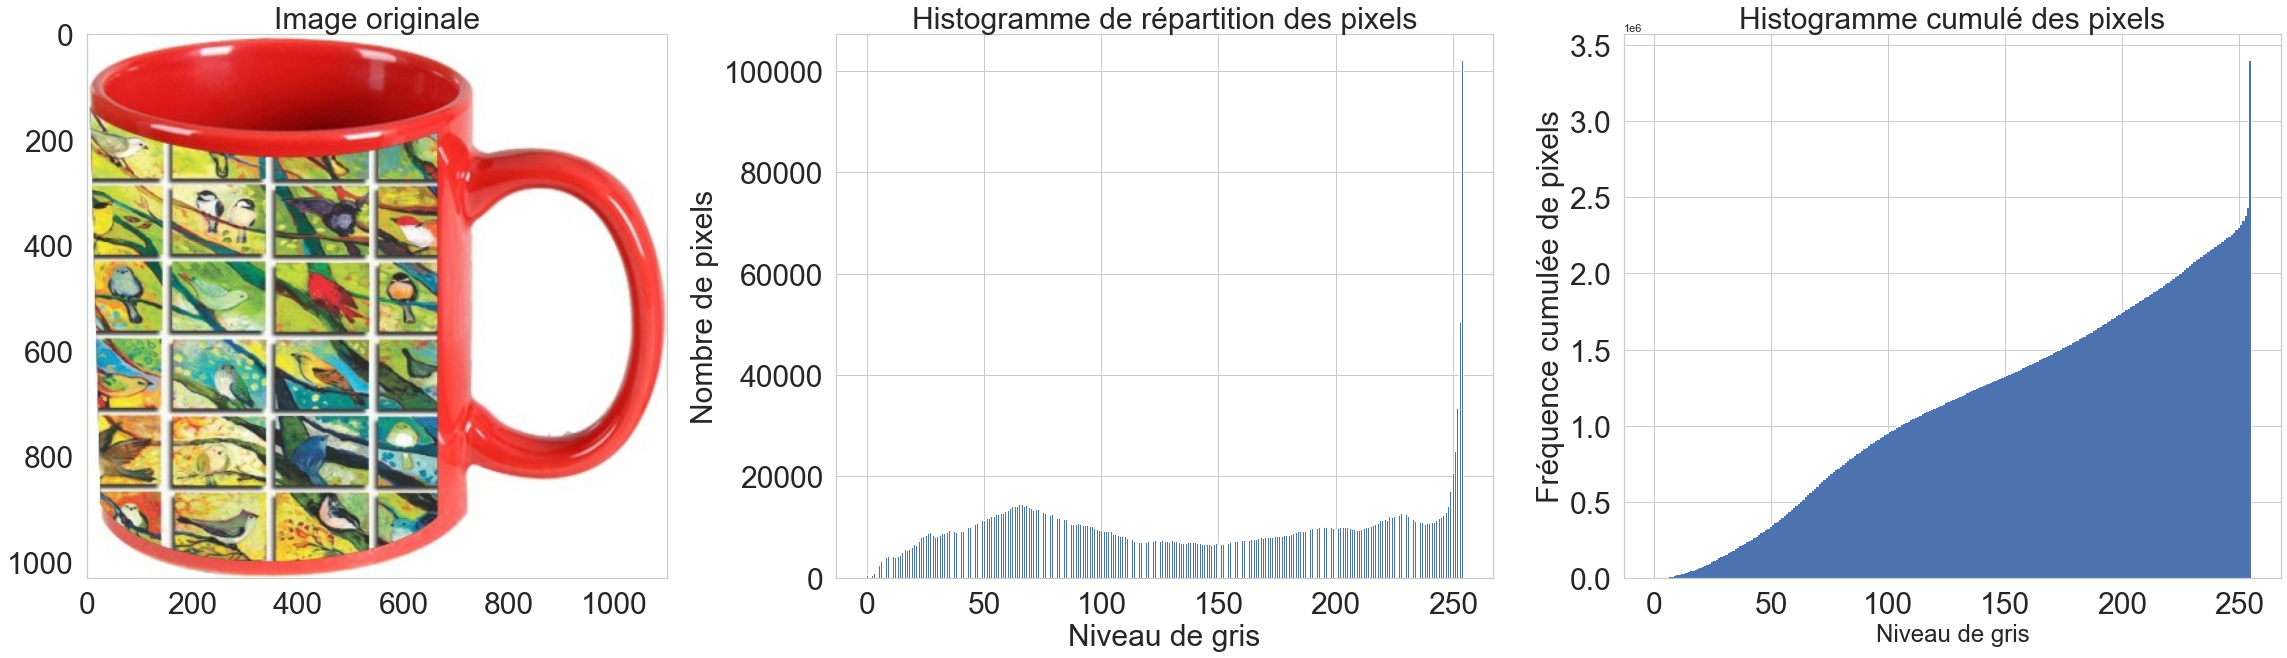

In [40]:
# Chargement de l'image originale comme matrice de pixels
img_orig = Image.open('../DataSet/Flipkart/Images/3c4ca34c50a5437a1bcc42b72fc1351f.jpg')
pf.afficher_image_histopixel(img_orig, 'Image originale')

<span style='background:Moccasin'>**Correction de l'exposition (étirement d'histogramme)**</span>

- Image sous-exposée ==> histogramme concentré à droite vers les niveaux de gris faible (255 = blanc).
- Image sur-exposée ==> histogramme concentré à gauche vers les niveaux de gris fort (0 = noir).

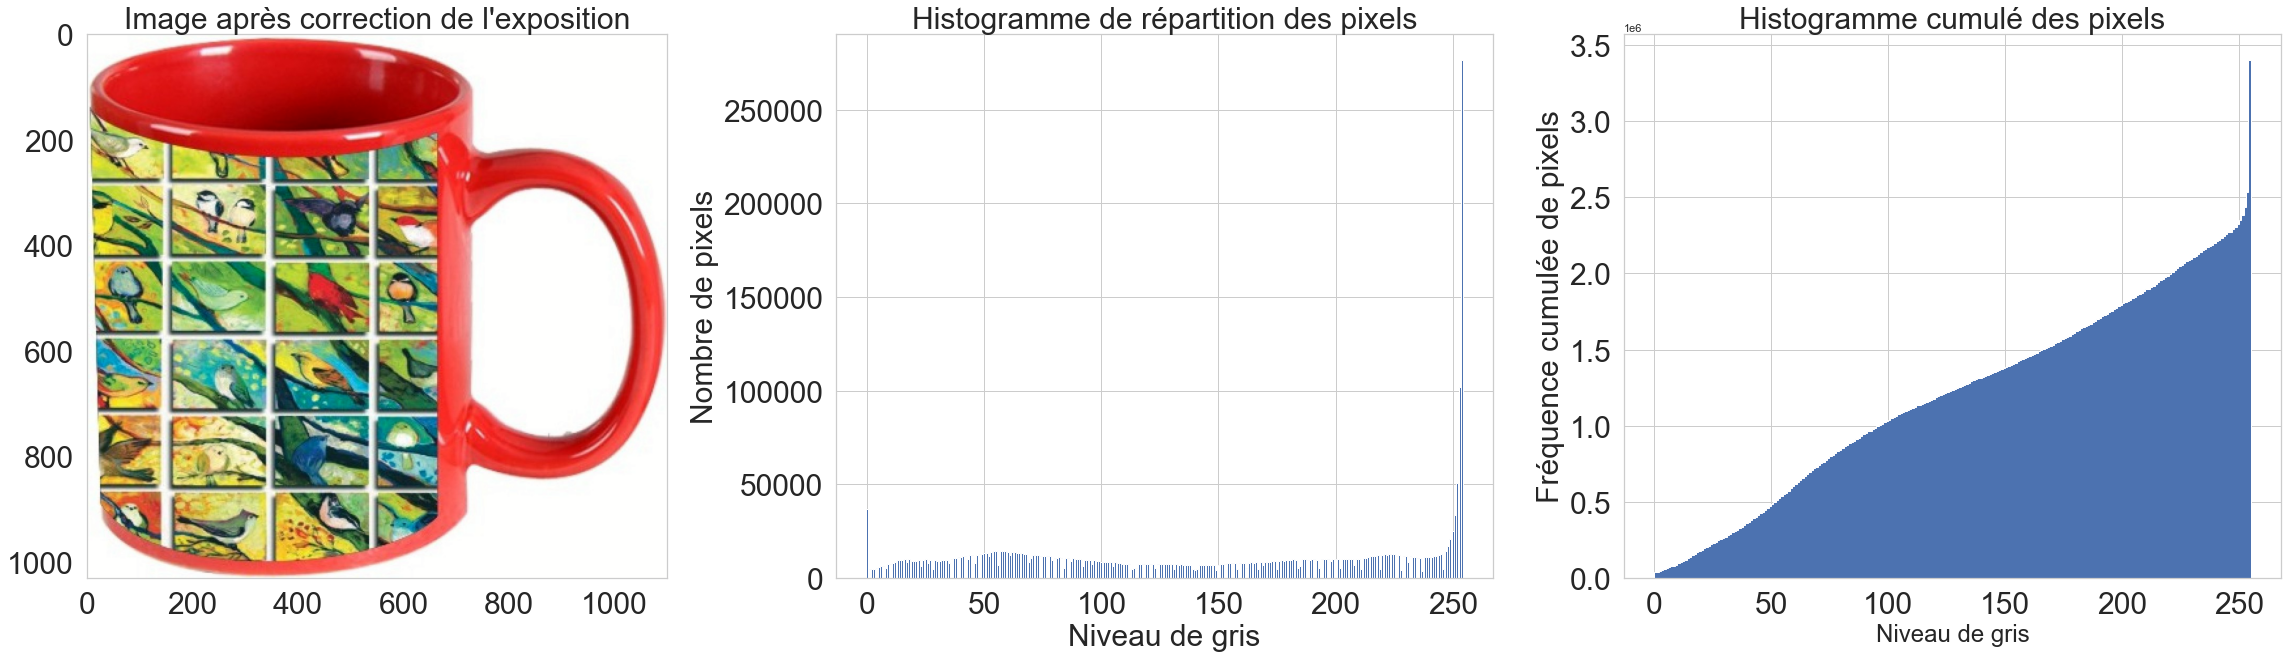

In [41]:
# Correction de l'exposition 
img_expo = ImageOps.autocontrast(img_orig, 1)
pf.afficher_image_histopixel(img_expo,'Image après correction de l\'exposition')

<span style='background:Moccasin'>**Correction du contraste (égalisation d'histogramme)**</span>

*Le contraste caractérise la répartition de lumière dans une image : plus une image est contrastée, plus la différence de luminosité entre ses zones claires et sombres est importante. En général, une image peu contrastée est terne, tandis qu'une image trop contrastée est visuellement "agressive". Dans les deux cas, l'image manque de clarté car certains de ses détails seront peu, voire pas du tout,  visibles.*

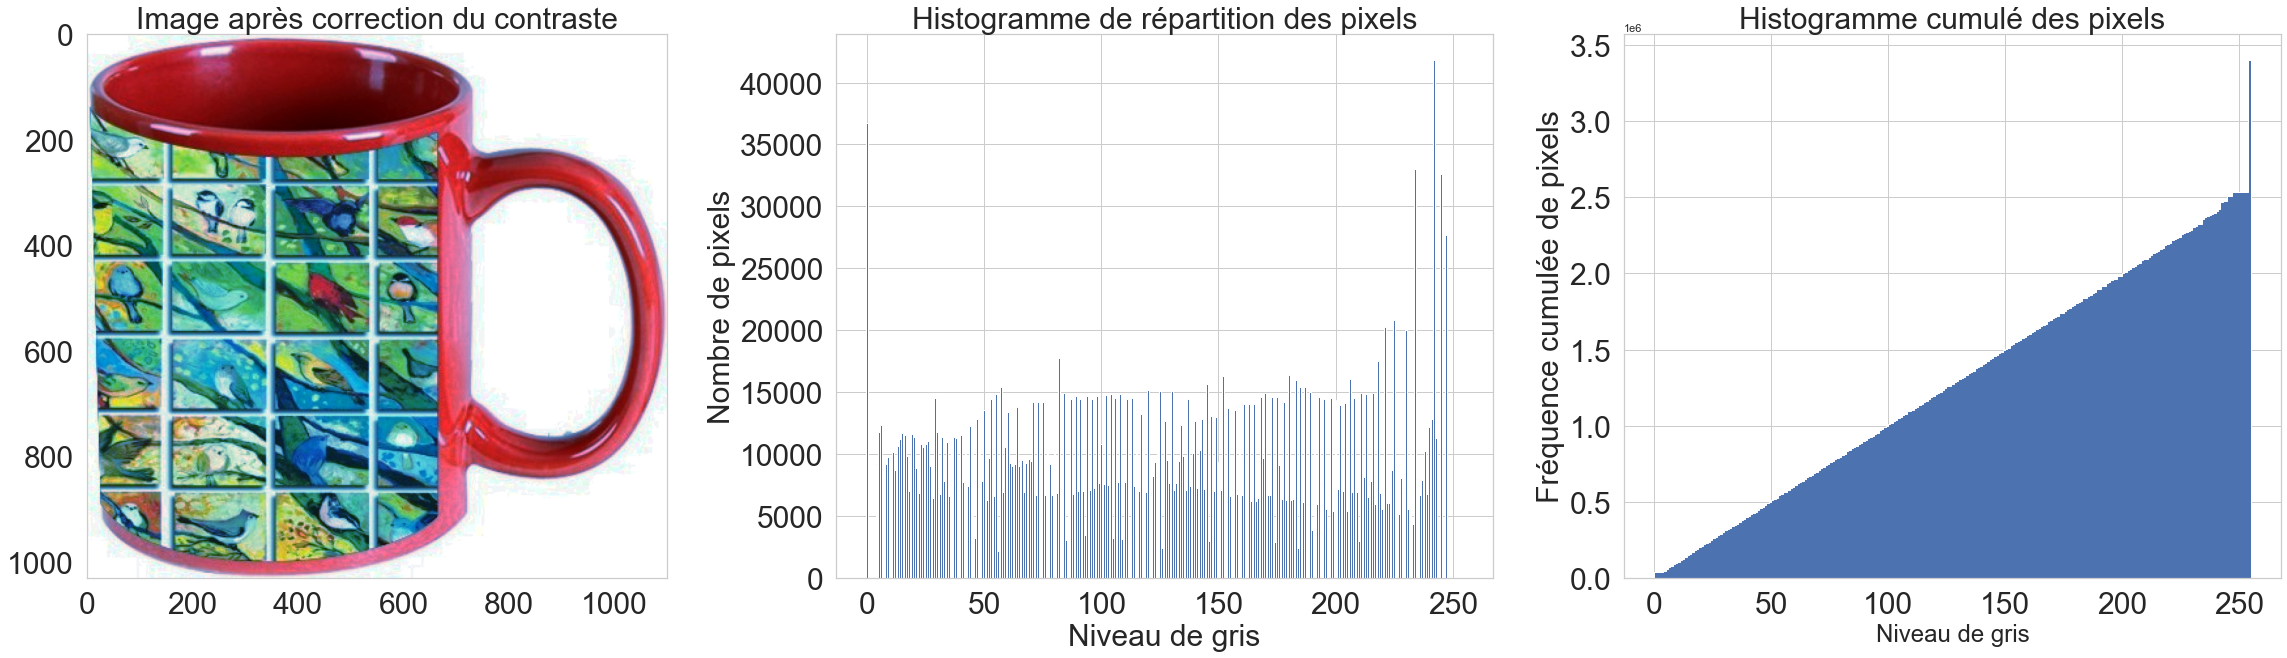

In [42]:
# Correction du contraste
img_contr_pils = ImageOps.equalize(img_expo)
pf.afficher_image_histopixel(img_contr_pils,'Image après correction du contraste')

<span style='background:Moccasin'>**Réduction du bruit (lissage)**</span>

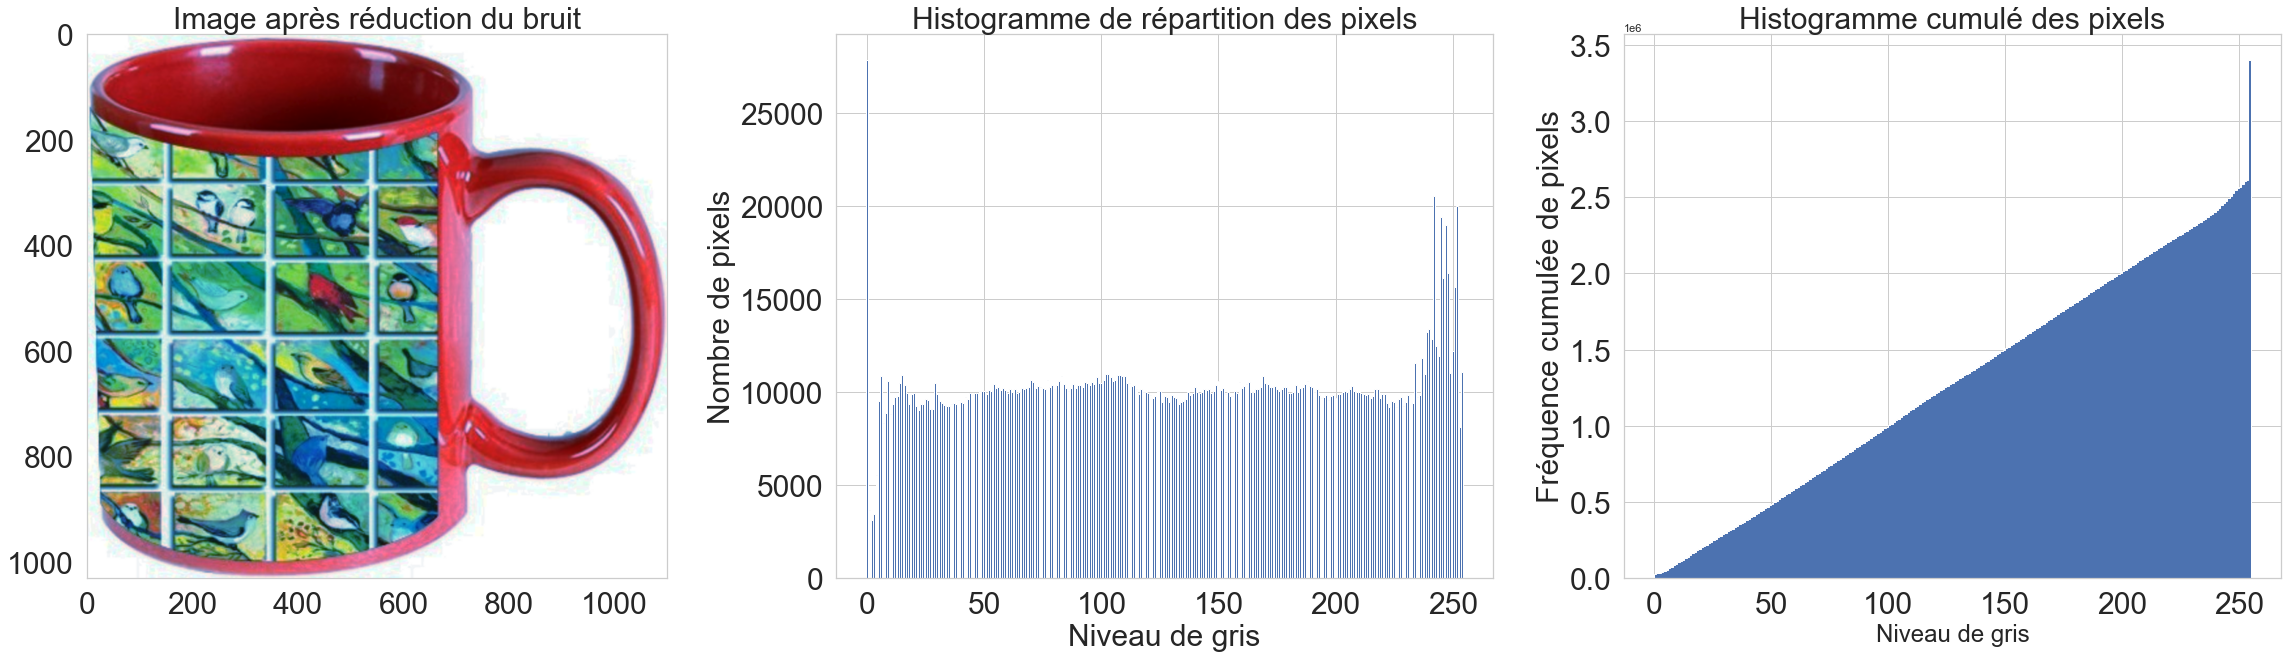

In [43]:
# Réduction du bruit (filtre)

img_filter = img_contr_pils.filter(ImageFilter.BoxBlur(1))
pf.afficher_image_histopixel(img_filter,'Image après réduction du bruit')

<span style='background:Moccasin'>**Convertir l'image en niveau de gris**</span>

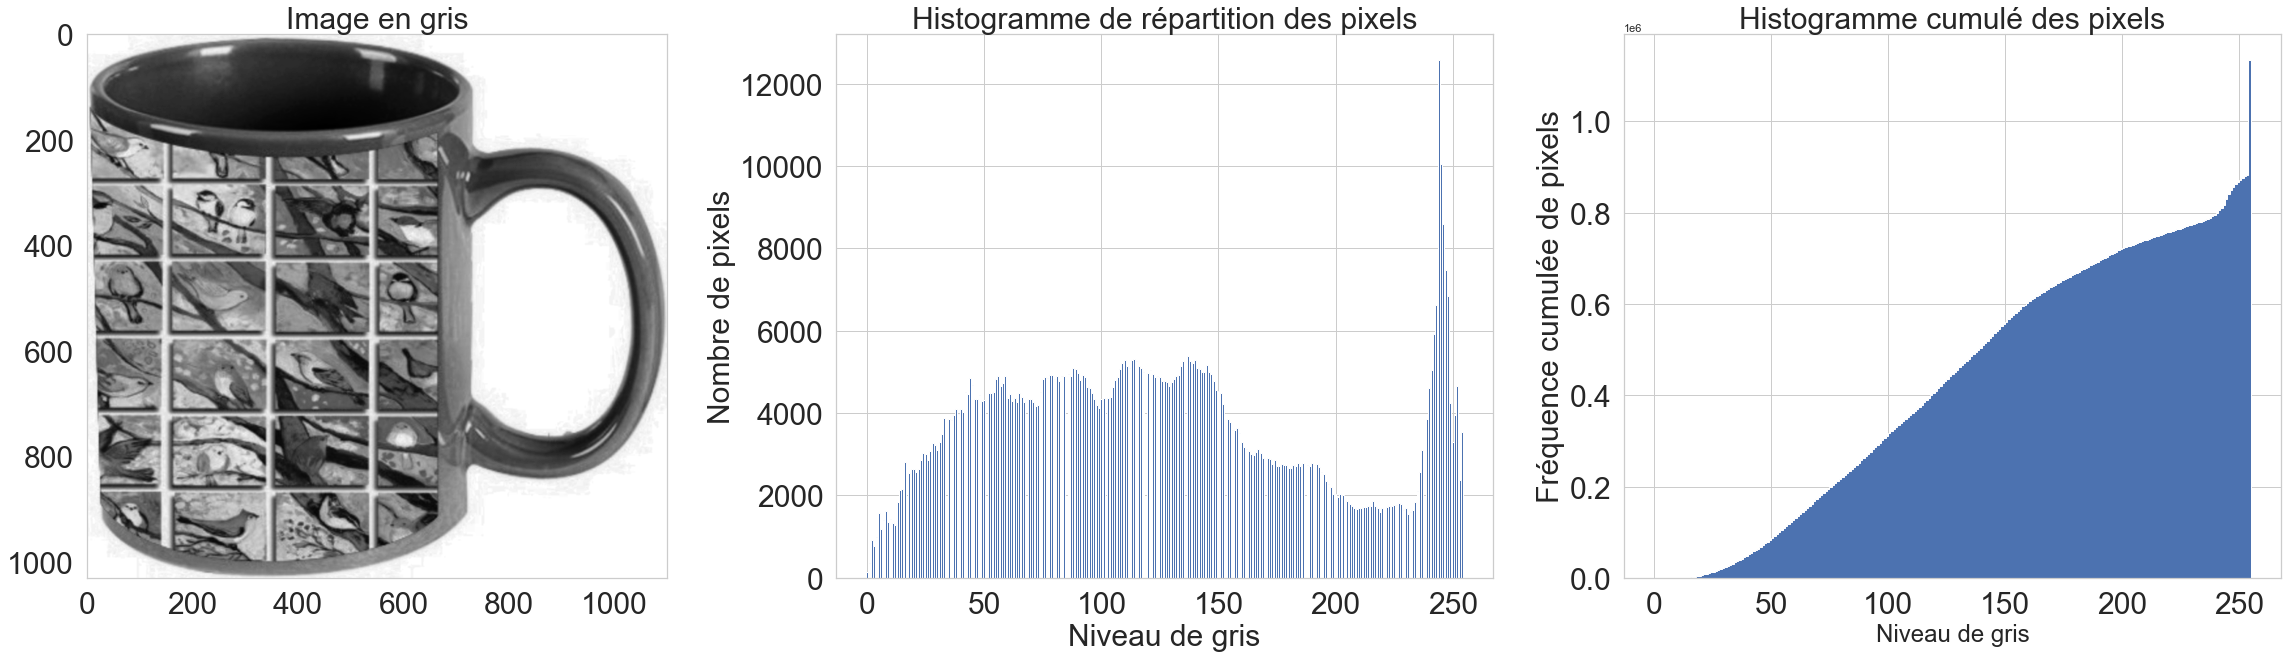

In [44]:
# Conversion de l'image en niveau de gris pour SIFT
img_gris = cv.cvtColor(np.array(img_filter), cv.COLOR_RGB2GRAY)
pf.afficher_image_histopixel(img_gris,'Image en gris')

<span style='background:Moccasin'>**Redimensionnement en 224 * 224**</span>

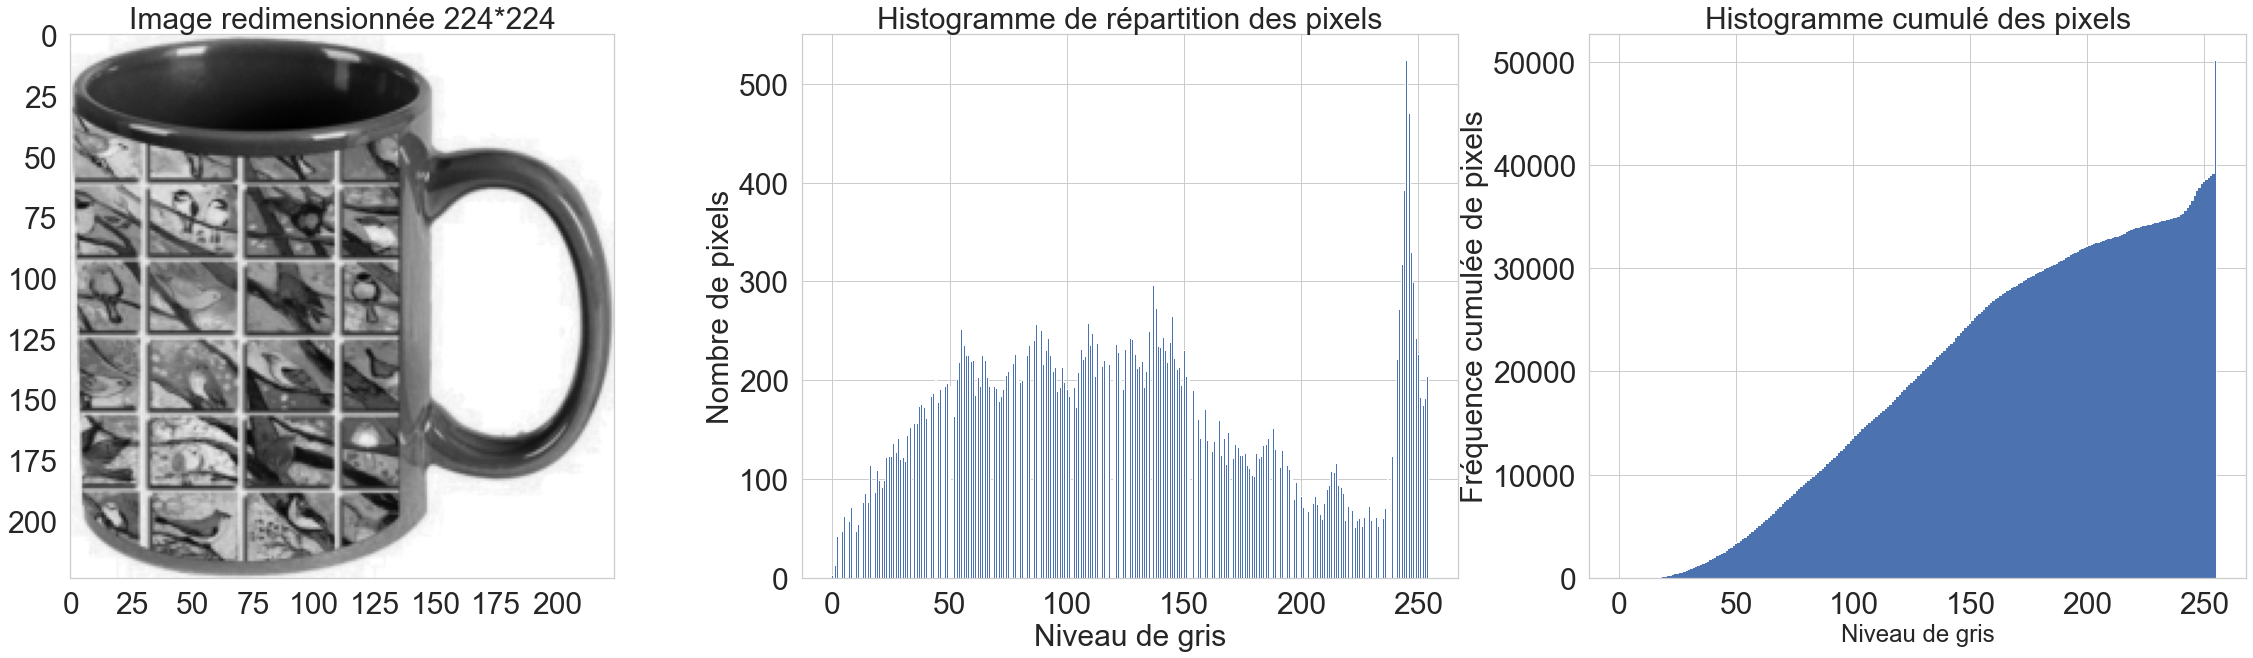

In [45]:
# Redimensionnement image contraste PILS
img_redim_pils = cv.resize(np.array(img_gris), dim,
                            interpolation=cv.INTER_AREA)
pf.afficher_image_histopixel(img_redim_pils,'Image redimensionnée 224*224')

#### 2.2.2 Pré-traitement de toutes les images

In [46]:
# Pré-traitement de toutes les images
products_image_data['image_proces'] = \
products_image_data['image_loc'].apply(pf.preprocess_image)

In [47]:
products_image_data.head(3)

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                           image_loc         category  \
0  ../DataSet/Flipkart/Images/55b85ea15a1536d46b7...  Home Furnishing   
1  ../DataSet/Flipkart/Images/7b72c92c2f6c4026862...        Baby Care   
2  ../DataSet/Flipkart/Images/64d5d4a258243731dc7...        Baby Care   

                                        image_proces  
0  ../DataSet/Flipkart/Images_process/55b85ea15a1...  
1  ../DataSet/Flipkart/Images_process/7b72c92c2f6...  
2  ../DataSet/Flipkart/Images_process/64d5d4a2582...

#### 2.2.3 Extraction des features

Nous allons utiliser l'algorithme SIFT (Scale Invariant Feature Transform)

La méthodoligie d'extraction de features par SIFT se fait en 3 étapes :

- Récupérer les descripteurs de chaque image par un algorithme de type SIFT
- Clusteriser l'ensemble de tous les descripteurs
- Construction de l'histogramme pour chaque image (Bag of Visual Words)

##### 2.2.3.1 Extraction des descripteurs sur une image (illustration)

In [48]:
# Chargement de l'image précédemment traitée
mug = cv.imread('../DataSet/Flipkart/Images_process/3c4ca34c50a5437a1bcc42b72fc1351f.jpg')

In [49]:
# Transformation del'image en matrice de pixels pour OpenCV
mug = np.array(mug)

# Extraction des keypoints et descripteurs SIFT
sift_keypoints, sift_descripteurs = pf.gen_sift_features(mug)

print(f"L'image contient {sift_descripteurs.shape[0]} descripteurs SIFT")
print(f'Chaque descripteur est un vecteur de longueur {sift_descripteurs.shape[1]}')

L'image contient 587 descripteurs SIFT
Chaque descripteur est un vecteur de longueur 128


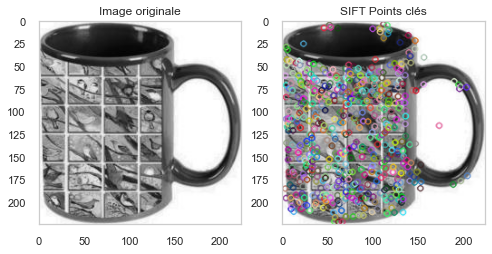

In [50]:
# Visualisation des points d'intérêt
sift_mug_keypoints = cv.drawKeypoints(mug, sift_keypoints, None)

plt.figure(figsize=(8, 4))
plt.grid(False)

# Image originale
plt.subplot(1, 2, 1)
plt.grid(False)
plt.title('Image originale')
plt.imshow(mug)

# Image avec les points clés
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(sift_mug_keypoints)
plt.title('SIFT Points clés')

plt.show()

##### 2.2.3.3 Etape 1: Extraction des descripteurs SIFT sur l'ensemble des images

Nous détectons les features, extrayons les descripteurs de chaque image du dataset et construisons un dictionnaire visuel.

In [51]:
# Chargement des images pré-traitées dans le dictionnaire images
images = pf.load_image_in_dict('../DataSet/Flipkart/Images_process')
print(f'{len(images)} images chargées')

1050 images chargées


In [52]:
#Extraction des descripteurs SIFT
sifts = pf.sift_features(images)

In [53]:
# Liste des descripteurs
descriptor_list = sifts[0] 
# Liste des vecteurs par images (dictionnaires clé=nom_image, vecteur)
all_bovw_feature = sifts[1]

print("Nombre de descripteurs : ", len(descriptor_list))

Nombre de descripteurs :  380820


##### 2.2.3.4 Etape 2: Clustering des descripteurs

Ensuite, nous créons des clusters à partir des descripteurs (avec K-Means). Le centre de chaque cluster sera utilisé comme vocabulaire du dictionnaire visuel.

Une règle empirique consiste à créer k clusters avec k = nombre de catégories * 10 (dans notre cas, c'est 70).

In [54]:
N_CLUSTERS = 70

In [55]:
# Récupère les centres de clusters qui sont les mots visuels    
visual_words = pf.kmeans(N_CLUSTERS, descriptor_list) 

##### 2.2.3.5 Etape 3: Construction de l'histogramme pour chaque image (Bag of Visual Words) 

Enfin, pour chaque image, on fait un histogramme de fréquence à partir des vocabulaires (les centres des clusters obtenus à l'étape précédente) et de la fréquence des vocabulaires dans l'image. Ces histogrammes sont nos sacs de mots visuels (BOVW).

In [56]:
# Création des histogrammes  
bovw = pf.image_class(all_bovw_feature, visual_words)

In [57]:
# Dataframe de sauvegarde des BOVW SIFT
df_bovw = pd.DataFrame({'image': bovw.keys(),'sift_bovw': bovw.values()})
# Ajout des BOVW en np.array d'une liste
df_bovw['Histo'] = [row[0] for row in df_bovw['sift_bovw']]
# Ajout de la catégorie
df_bovw = df_bovw.merge(products_image_data[['image', 'image_loc','category']], how='left', on='image')

df_bovw.head(3)

image  \
0  009099b1f6e1e8f893ec29a7023153c4.jpg   
1  0096e89cc25a8b96fb9808716406fe94.jpg   
2  00cbbc837d340fa163d11e169fbdb952.jpg   

                                           sift_bovw  \
0  [[2.0, 1.0, 4.0, 5.0, 26.0, 4.0, 2.0, 1.0, 1.0...   
1  [[1.0, 2.0, 2.0, 0.0, 5.0, 0.0, 0.0, 1.0, 0.0,...   
2  [[4.0, 0.0, 3.0, 6.0, 6.0, 0.0, 2.0, 18.0, 0.0...   

                                               Histo  \
0  [2.0, 1.0, 4.0, 5.0, 26.0, 4.0, 2.0, 1.0, 1.0,...   
1  [1.0, 2.0, 2.0, 0.0, 5.0, 0.0, 0.0, 1.0, 0.0, ...   
2  [4.0, 0.0, 3.0, 6.0, 6.0, 0.0, 2.0, 18.0, 0.0,...   

                                           image_loc          category  
0  ../DataSet/Flipkart/Images/009099b1f6e1e8f893e...           Watches  
1  ../DataSet/Flipkart/Images/0096e89cc25a8b96fb9...  Kitchen & Dining  
2  ../DataSet/Flipkart/Images/00cbbc837d340fa163d...   Home Furnishing

In [58]:
# La matrice des histogrammes
hist_vectors=[]
for key,value in bovw.items():
    hist_vectors.append(value[0])
    
im_features = np.asarray(hist_vectors)

In [59]:
im_features.shape

(1050, 70)

**Visualisation de l'histogramme pour notre image exemple**

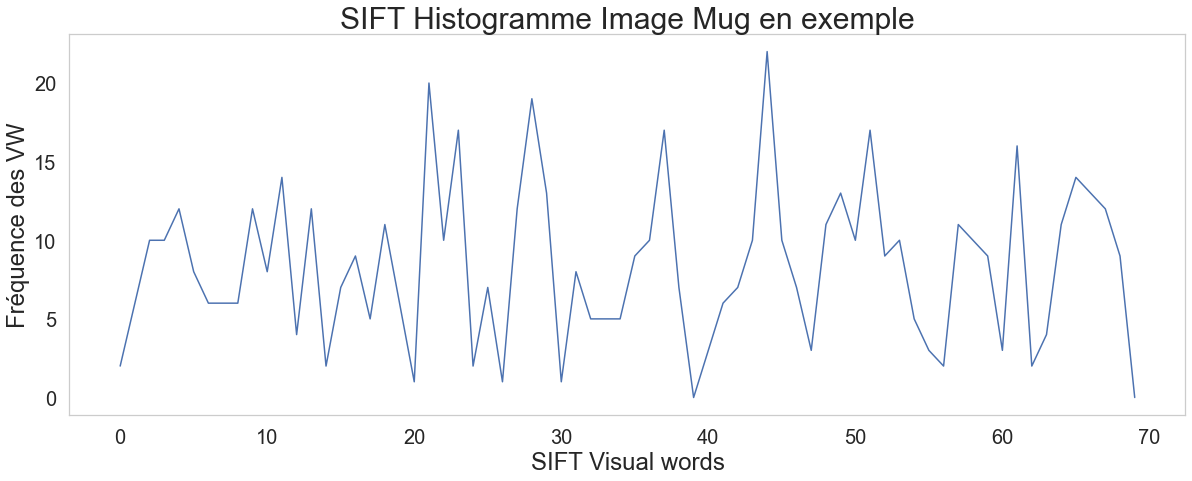

In [60]:
# Récupération de l'historgramme
df_visu = df_bovw[df_bovw['image'] ==
                       '3c4ca34c50a5437a1bcc42b72fc1351f.jpg']['sift_bovw']
histo_mug = df_visu.to_list()[0][0]
plt.figure(figsize=(20, 7))
plt.title('SIFT Histogramme Image Mug en exemple', fontsize=30)
plt.xlabel("SIFT Visual words", fontsize=24)
plt.ylabel("Fréquence des VW", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(False)
plt.plot(histo_mug)
plt.show()

___
## 3. REDUCTION DE DIMENSION

Nous allons utiliser 2 techniques :
- Analyse en Composantes Principales (ACP)
- t-distributed stochastic neighbor embedding (t-SNE)

### 3.1 Textes

Les matrices BOW et TF-IDF donnent des matrices creuses et imposantes. 

Une réduction dimensionnelle pourra aider à "condenser" ces matrices en faisant ressortir de nouvelles features qui "résumeront" les features initiales. 

Cela nous permettra par la suite de visualiser ces jeux de données, tout en réduisant les temps de calcul.

#### 3.1.1 PCA

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99% dans notre cas)

##### 3.1.1.1 BOW

In [61]:
print("Dimensions dataset avant réduction PCA : ", bow_vect.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_bow= pca.fit_transform(bow_vect)
print("Dimensions dataset après réduction PCA : ", pca_results_bow.shape)

Dimensions dataset avant réduction PCA :  (1050, 6121)
Dimensions dataset après réduction PCA :  (1050, 786)


##### 3.1.1.2 TF-IDF

In [62]:
print("Dimensions dataset avant réduction PCA : ", tfidf_vect.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_tfidf= pca.fit_transform(tfidf_vect)
print("Dimensions dataset après réduction PCA : ", pca_results_tfidf.shape)

Dimensions dataset avant réduction PCA :  (1050, 6121)
Dimensions dataset après réduction PCA :  (1050, 906)


##### 3.1.1.3 Word2Vec

In [63]:
print("Dimensions dataset avant réduction PCA : ", vector_w2v_desc_lem.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_word2vec= pca.fit_transform(vector_w2v_desc_lem)
print("Dimensions dataset après réduction PCA : ", pca_results_word2vec.shape)


Dimensions dataset avant réduction PCA :  (1050, 100)
Dimensions dataset après réduction PCA :  (1050, 91)


#### 3.1.2 TSNE

Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des textes

##### 3.1.2.1 BOW

In [64]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_bow = tsne.fit_transform(pca_results_bow)

df_tsne_bow = pd.DataFrame(tsne_results_bow[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bow["class"] = products_text_data["category"]
print(df_tsne_bow.shape)

(1050, 3)


##### 3.1.2.2 TF-IDF

In [65]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_tfidf = tsne.fit_transform(pca_results_tfidf)

df_tsne_tfidf = pd.DataFrame(tsne_results_tfidf[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_tfidf["class"] = products_text_data["category"]
print(df_tsne_tfidf.shape)

(1050, 3)


##### 3.1.2.3 Word2Vec

In [66]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_word2vec = tsne.fit_transform(pca_results_word2vec)

df_tsne_word2vec = pd.DataFrame(tsne_results_word2vec[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_word2vec["class"] = products_text_data["category"]
print(df_tsne_word2vec.shape)

(1050, 3)


#### 3.1.3 Visualisation

Affichage T-SNE selon les catégories d'images

##### 3.1.3.1 BOW

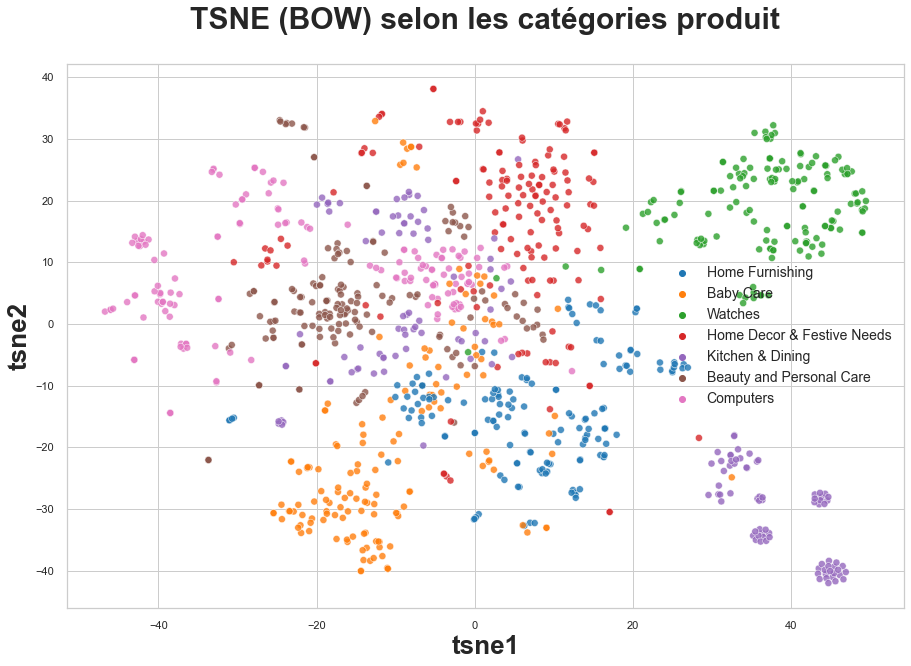

In [67]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_bow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BOW) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

##### 3.1.3.2 TF-IDF

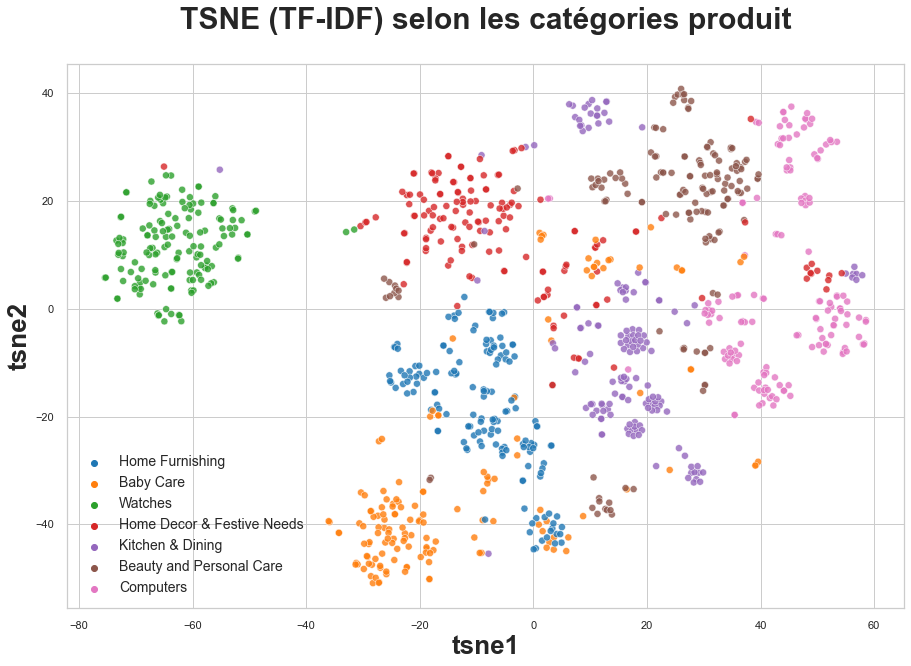

In [68]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_tfidf, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (TF-IDF) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

##### 3.1.3.3 Word2Vec

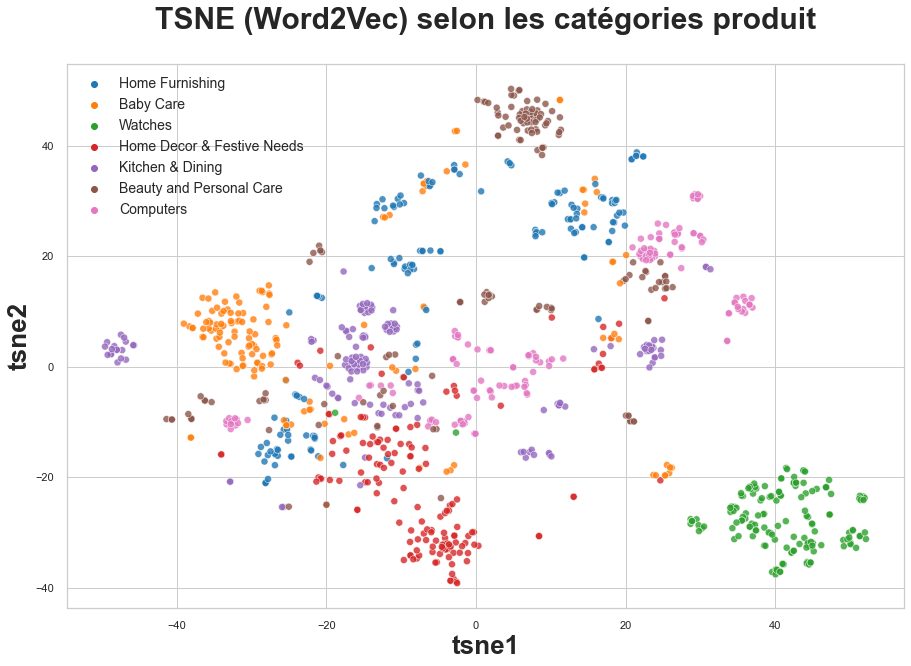

In [69]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_word2vec, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (Word2Vec) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

**Observations**

- Les affichages des données textes (à partir TF-IDF et Word2Vec) permettent de mieux observer une sorte de regroupement des points appartenant à la même catégorie produit. 
- On observe même qu'avec les feaures construits avec TF-IDF, les points appartenant à la catégorie *Watches* sont très bien regroupés et le groupe est bien séparé des autres groupes. 

### 3.2 Images

#### 3.2.1 PCA

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99% dans notre cas)

In [70]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_img = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", pca_results_img.shape)

Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 59)


#### 3.2.2 TSNE

Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [71]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_img = tsne.fit_transform(pca_results_img)

df_tsne_img = pd.DataFrame(tsne_results_img[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_img["class"] = products_image_data["category"]
print(df_tsne_img.shape)

(1050, 3)


#### 3.2.3 Visualisation

Affichage T-SNE selon les catégories d'images

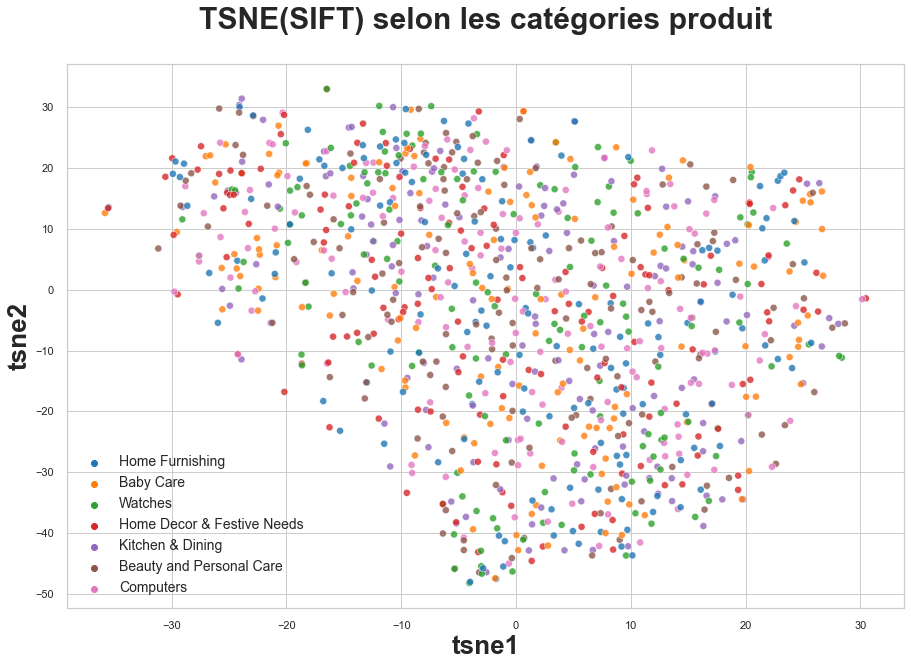

In [72]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_img, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE(SIFT) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

**Observation**

Le regroupement par catégories produits est moins perceptible que ce qu'on a pu observer sur les données textuelles.

___
## 4. CLUSTERING

In [73]:
N_CLUSTERS = 7 # On a 7 catégories produit

### 4.1 Textes

La visualisation t-SNE sur les features TF-IDF et Word2Vec ayant permis d'observer un meilleur regroupement des catégories, ce sont ces features que nous conserverons pour le clustering.

#### 4.1.1 TF-IDF

In [74]:
#Création de clusters à partir du T-SNE 
X = df_tsne_tfidf[["tsne1","tsne2"]]

cls = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls.fit(X)

df_tsne_tfidf["cluster"] = cls.labels_

sil = silhouette_score(X,cls.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

Le score de silhouette est 0.4785338


In [75]:
# Création des labels à partir du nom de catégorie produit
le = preprocessing.LabelEncoder()
products_text_data["label"] = le.fit_transform(products_text_data["category"])

In [76]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


In [77]:
list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs", "Home Furnishing", "Kitchen & Dining", "Watches"]

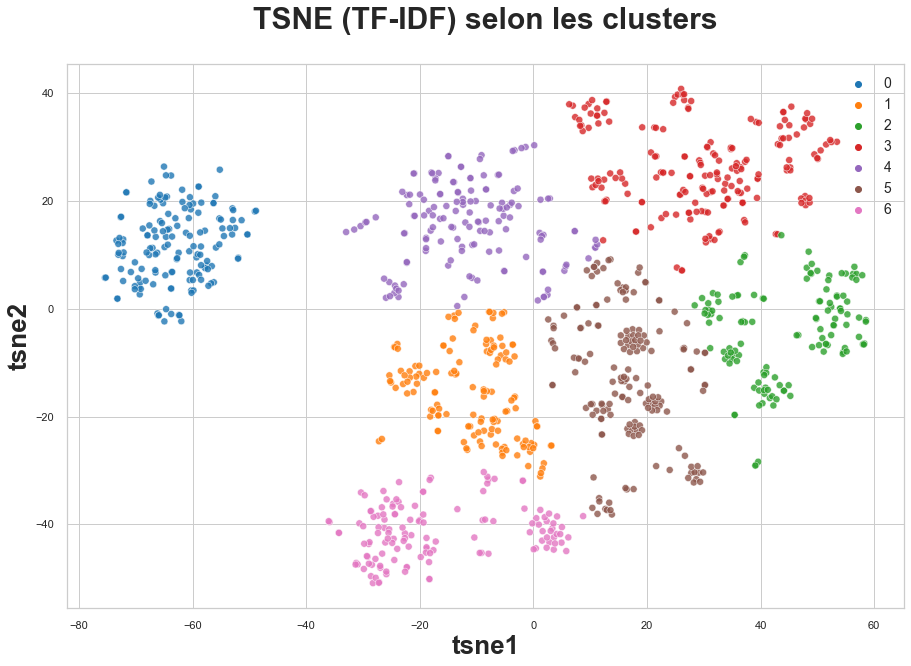

ARI :  0.5972551327471095


In [78]:
#Affichage des images selon clusters et calcul ARI de similarité catégories produit / clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_tfidf,
    legend="brief")

plt.title('TSNE (TF-IDF) selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = products_text_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

**Qualité de la catégorisation**

In [79]:
df_tsne_tfidf.groupby("cluster").count()["class"]

cluster
0    150
1    137
2    128
3    188
4    147
5    166
6    134
Name: class, dtype: int64

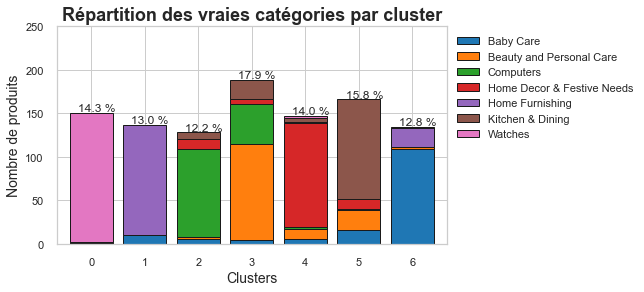

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               0.0                       0.0        0.0   
1              10.0                       0.0        0.0   
2               5.0                       3.0      101.0   
3               4.0                     111.0       46.0   
4               6.0                      11.0        2.0   
5              16.0                      23.0        1.0   
6             109.0                       2.0        0.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                1.0              0.0               1.0   
1                                0.0            127.0               0.0   
2                               11.0              0.0               8.0   
3                                6.0              0.0              21.0   
4                              120.0              1.0               5.0   
5                               12.0              0.0             114.0   
6                                0.0             22.0               1.0   

category  Watches  
label              
0           148.0  
1             0.0  
2             0.0  
3             0.0  
4             2.0  
5             0.0  
6             0.0

In [80]:
pf.plot_stacked_bar_clust_vs_cat(df_tsne_tfidf["cluster"],
                              df_tsne_tfidf["class"],
                              df_tsne_tfidf,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,250))

In [81]:
cat_clust_confmat = pf.plot_conf_matrix_cat_vs_clust(df_tsne_tfidf['class'],
                                                  df_tsne_tfidf['cluster'],
                                                  normalize=False,
                                                  margins_sums=True,
                                                  margins_score=True)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(cat_clust_confmat)

cluster                      6   3   2   4   1   5   0 cat_sum  \
class                                                            
Baby Care                  109   4   5   6  10  16   0     150   
Beauty and Personal Care     2 111   3  11   0  23   0     150   
Computers                    0  46 101   2   0   1   0     150   
Home Decor & Festive Needs   0   6  11 120   0  12   1     150   
Home Furnishing             22   0   0   1 127   0   0     150   
Kitchen & Dining             1  21   8   5   0 114   1     150   
Watches                      0   0   0   2   0   0 148     150   
clust_sum                  134 188 128 147 137 166 150       -   
clust_matching_score_pct    81  59  79  82  93  69  99       -   

cluster                    cat_matching_score_pct  
class                                              
Baby Care                                      73  
Beauty and Personal Care                       74  
Computers                                      67  
Home Decor & Festive Needs                     80  
Home Furnishing                                85  
Kitchen & Dining                               76  
Watches                                        99  
clust_sum                                       -  
clust_matching_score_pct                        -

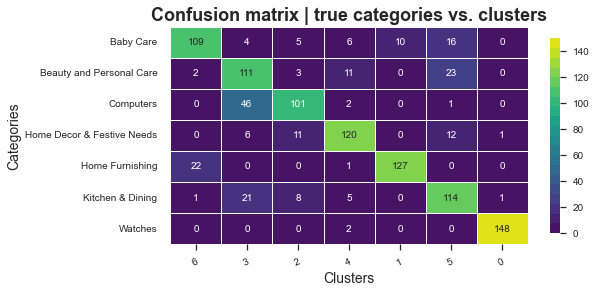

In [82]:
# Affiche la matrice de confusion (Vraies catégories vs. Clusters)

cm = pf.plot_conf_matrix_cat_vs_clust(df_tsne_tfidf['class'],
                            df_tsne_tfidf['cluster'],
                            normalize=False,
                            margins_sums=False,
                            margins_score=False)
pf.plot_heatmap(cm, "Confusion matrix | true categories vs. clusters",
             figsize=(8, 4), vmin=0, vmax=150, center=75,
                 palette=sns.color_palette("viridis", 20), shape='rect',
                 fmt='.0f', robust=False, fig=None, ax=None)

#### 4.1.2 Word2Vec

In [83]:
#Création de clusters à partir du T-SNE 
X = df_tsne_word2vec[["tsne1","tsne2"]]

cls = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls.fit(X)

df_tsne_word2vec["cluster"] = cls.labels_

sil = silhouette_score(X,cls.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

Le score de silhouette est 0.46355656


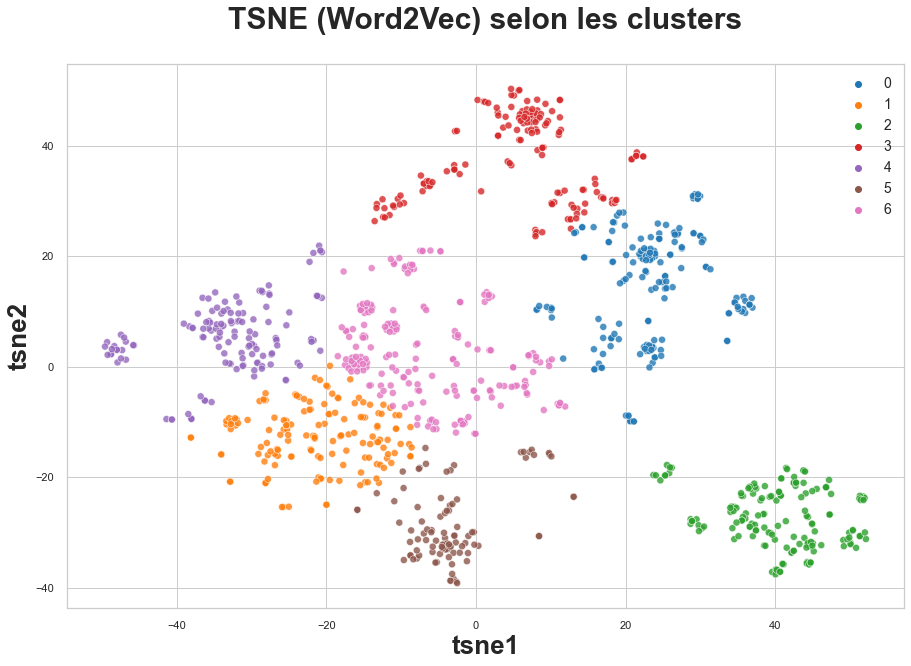

ARI :  0.32154304518205107


In [84]:
#Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_word2vec,
    legend="brief")

plt.title('TSNE (Word2Vec) selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = products_text_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

**Qualité de la catégorisation**

In [85]:
df_tsne_word2vec.groupby("cluster").count()["class"]

cluster
0    164
1    153
2    157
3    147
4    136
5     94
6    199
Name: class, dtype: int64

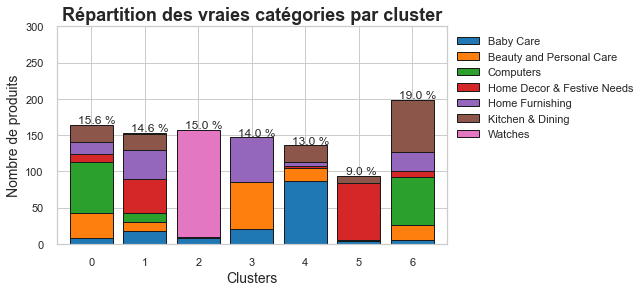

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               8.0                      34.0       71.0   
1              17.0                      13.0       13.0   
2               8.0                       0.0        0.0   
3              21.0                      64.0        0.0   
4              87.0                      17.0        0.0   
5               4.0                       1.0        0.0   
6               5.0                      21.0       66.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                               11.0             17.0              23.0   
1                               47.0             40.0              22.0   
2                                1.0              0.0               0.0   
3                                0.0             62.0               0.0   
4                                3.0              6.0              23.0   
5                               79.0              0.0              10.0   
6                                9.0             25.0              72.0   

category  Watches  
label              
0             0.0  
1             1.0  
2           148.0  
3             0.0  
4             0.0  
5             0.0  
6             1.0

In [86]:
pf.plot_stacked_bar_clust_vs_cat(df_tsne_word2vec["cluster"],
                              df_tsne_word2vec["class"],
                              df_tsne_word2vec,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

In [87]:
cat_clust_confmat = pf.plot_conf_matrix_cat_vs_clust(df_tsne_word2vec['class'],
                                                  df_tsne_word2vec['cluster'],
                                                  normalize=False,
                                                  margins_sums=True,
                                                  margins_score=True)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(cat_clust_confmat)

cluster                      4   3   0  5   1   6   2 cat_sum  \
class                                                           
Baby Care                   87  21   8  4  17   5   8     150   
Beauty and Personal Care    17  64  34  1  13  21   0     150   
Computers                    0   0  71  0  13  66   0     150   
Home Decor & Festive Needs   3   0  11 79  47   9   1     150   
Home Furnishing              6  62  17  0  40  25   0     150   
Kitchen & Dining            23   0  23 10  22  72   0     150   
Watches                      0   0   0  0   1   1 148     150   
clust_sum                  136 147 164 94 153 199 157       -   
clust_matching_score_pct    64  44  43 84  26  36  94       -   

cluster                    cat_matching_score_pct  
class                                              
Baby Care                                      58  
Beauty and Personal Care                       43  
Computers                                      47  
Home Decor & Festive Needs                     53  
Home Furnishing                                27  
Kitchen & Dining                               48  
Watches                                        99  
clust_sum                                       -  
clust_matching_score_pct                        -

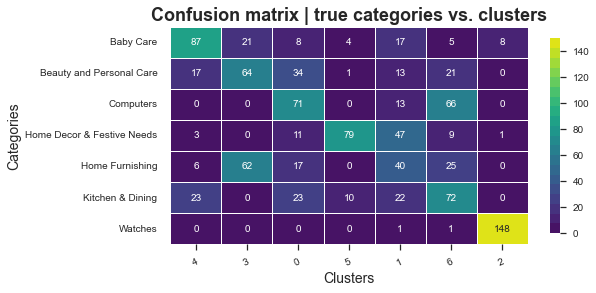

In [88]:
# Affiche la matrice de confusion (Vraies catégories vs. Clusters)

cm = pf.plot_conf_matrix_cat_vs_clust(df_tsne_word2vec['class'],
                            df_tsne_word2vec['cluster'],
                            normalize=False,
                            margins_sums=False,
                            margins_score=False)
pf.plot_heatmap(cm, "Confusion matrix | true categories vs. clusters",
             figsize=(8, 4), vmin=0, vmax=150, center=75,
                 palette=sns.color_palette("viridis", 20), shape='rect',
                 fmt='.0f', robust=False, fig=None, ax=None)

**Recap**

*TF-IDF*

- ARI = 0.59
- Silhouette = 0.48
- 220 erreurs de catégorisation

*Word2Vec*

- ARI = 0.34
- Silhouette = 0.45
- 485 erreurs de catégorisation

**Observation générale**
- les scores ARI et de silhouette sont plutôt moyennement bons sur les features textuels.
- ce qui suggère qu'une classification des produits à partir des données textuelles serait plutôt faisable

### 4.2 Images

In [89]:
#Création de clusters à partir du T-SNE 
X = df_tsne_img[["tsne1","tsne2"]]

cls = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls.fit(X)

df_tsne_img["cluster"] = cls.labels_

sil = silhouette_score(X,cls.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

Le score de silhouette est 0.35016045


In [90]:
# Création des labels à partir du nom de catégory produit
products_image_data["label"] = le.fit_transform(products_image_data["category"])

In [91]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


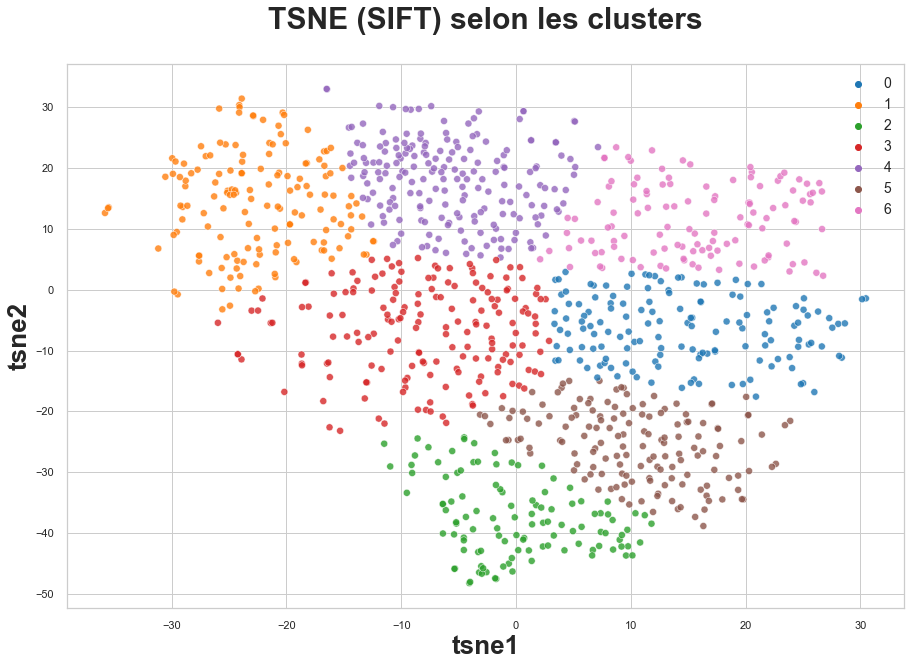

ARI :  -0.0013782024386973432


In [92]:
#Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_img,
    legend="brief")

plt.title('TSNE (SIFT) selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = products_image_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

**Observations** 
- le score ARI est très mauvais
- le score de silhouette est moins bon que celui obtenu sur les données textes

**Qualité de la catégorisation**

In [93]:
df_tsne_img.groupby("cluster").count()["class"]

cluster
0    145
1    151
2    113
3    175
4    196
5    150
6    120
Name: class, dtype: int64

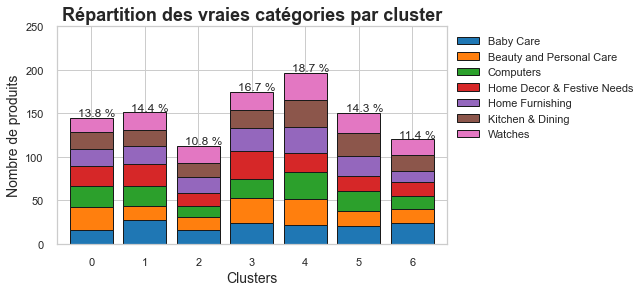

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0                16                        26         25   
1                27                        17         23   
2                16                        15         13   
3                24                        29         21   
4                22                        30         30   
5                21                        17         23   
6                24                        16         15   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                 23               19                19   
1                                 25               20                19   
2                                 14               19                16   
3                                 33               26                21   
4                                 22               30                31   
5                                 17               23                26   
6                                 16               13                18   

category  Watches  
label              
0              17  
1              20  
2              20  
3              21  
4              31  
5              23  
6              18

In [94]:
pf.plot_stacked_bar_clust_vs_cat(df_tsne_img["cluster"],
                              df_tsne_img["class"],
                              df_tsne_img,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,250))

In [95]:
cat_clust_confmat = pf.plot_conf_matrix_cat_vs_clust(df_tsne_img['class'],
                                                  df_tsne_img['cluster'],
                                                  normalize=False,
                                                  margins_sums=True,
                                                  margins_score=True)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(cat_clust_confmat)

cluster                      6   0   1   3   4   5   2 cat_sum  \
class                                                            
Baby Care                   24  16  27  24  22  21  16     150   
Beauty and Personal Care    16  26  17  29  30  17  15     150   
Computers                   15  25  23  21  30  23  13     150   
Home Decor & Festive Needs  16  23  25  33  22  17  14     150   
Home Furnishing             13  19  20  26  30  23  19     150   
Kitchen & Dining            18  19  19  21  31  26  16     150   
Watches                     18  17  20  21  31  23  20     150   
clust_sum                  120 145 151 175 196 150 113       -   
clust_matching_score_pct    20  18  15  19  15  17  18       -   

cluster                    cat_matching_score_pct  
class                                              
Baby Care                                      16  
Beauty and Personal Care                       17  
Computers                                      15  
Home Decor & Festive Needs                     22  
Home Furnishing                                20  
Kitchen & Dining                               17  
Watches                                        13  
clust_sum                                       -  
clust_matching_score_pct                        -

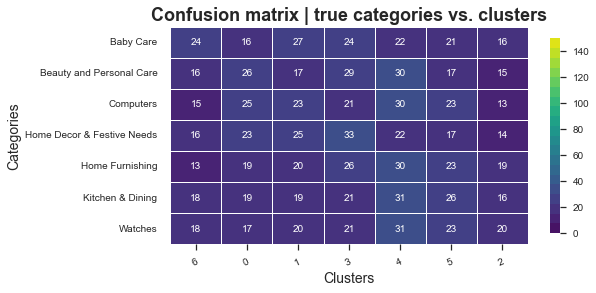

In [96]:
# Affiche la matrice de confusion (Vraies catégories vs. Clusters)

cm = pf.plot_conf_matrix_cat_vs_clust(df_tsne_img['class'],
                            df_tsne_img['cluster'],
                            normalize=False,
                            margins_sums=False,
                            margins_score=False)
pf.plot_heatmap(cm, "Confusion matrix | true categories vs. clusters",
             figsize=(8, 4), vmin=0, vmax=150, center=75,
                 palette=sns.color_palette("viridis", 20), shape='rect',
                 fmt='.0f', robust=False, fig=None, ax=None)

**Observations**

- ARI = -0.00019
- Silhouette = 0.37
- 867 erreurs de catégorisation

Les catégorisation avec les features SIFT ne permet pas vraiment de retrouver les vraies catégories produit (score ARI très mauvais)

___
## 5. CONCLUSION

- L'utilisation des données texte (features TF-IDF) permet une meilleur catégorisation des produits par rapport aux données image.
- La classification avec les données images pouraient certainement être améliorée en utilisant un algorithme de type CNN (Transfer Learning). Nous allons le tester dans la section ANNEXE

>**Nous validons la faisabilité de la mise en oeuvre d'un moteur de classification automatique des produits**




___
## 6. ANNEXE 

### 6.1  EXPLORATION DES TOPICS

On va tester 2 approches non supervisées, afin de voir si les topics abordés dans les documents permettraient de classifier un produit : 
- Latent Dirichlet Allocation (LDA)
- Negative Matrix Factorization (NMF)

#### 6.1.1 Latent Dirichlet Allocation (LDA)

In [97]:
n_topics = 7
n_top_words = 10

# Créer le modèle LDA
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50,
                                random_state=0)

##### 6.1.1.1 Données Bag of Words

In [98]:
# Fitter sur les données
lda.fit(bow_vect)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          max_iter=5, n_components=7, random_state=0)

In [99]:
print("Catégories in LDA model (BOW):")
bow_feature_names = bow.get_feature_names()

pf.print_top_words(lda, bow_feature_names, n_top_words)

Catégories in LDA model (BOW):
Catégorie #0:
laptop skin baby shape print girl set warranty pad type
Catégorie #1:
quilt dohar comforter single bluetooth idli oudh pot kid heat
Catégorie #2:
jewellery vanity makeup box case help shadow learning handloom compartment
Catégorie #3:
warranty product combo watch set apple boy free men covered
Catégorie #4:
cm mug design material feature product color price pack home
Catégorie #5:
product buy free shipping genuine cash delivery replacement 30 day
Catégorie #6:
usb bowl singing steel sstudio surgical stainless keyboard pant pizza



Analysons les proportions de produits des différentes catégories connues pour chaque topic, afin de voir s'il est possible de faire des couples (catégorie, topic) uniques.

In [100]:
pf.get_categories_per_topic(n_topics, 
                            lda, 
                            bow_vect, 
                            products_text_data)

% Home Furnishing  % Baby Care  % Watches  \
Topic                                              
0.0             1.111111    52.222222   7.222222   
1.0            25.000000     6.250000   0.000000   
2.0             0.000000     0.000000   0.000000   
3.0             0.000000     7.692308  23.076923   
4.0            32.773109     7.983193   0.000000   
5.0            12.406015     5.827068  24.060150   
6.0             0.000000     5.263158   0.000000   

       % Home Decor & Festive Needs  % Kitchen & Dining  \
Topic                                                     
0.0                        3.888889            5.555556   
1.0                       25.000000           31.250000   
2.0                        0.000000            0.000000   
3.0                        0.000000           15.384615   
4.0                       24.369748           29.411765   
5.0                       14.661654            8.834586   
6.0                        7.894737           31.578947   

       % Beauty and Personal Care  % Computers  
Topic                                           
0.0                     13.888889    16.111111  
1.0                      6.250000     6.250000  
2.0                     85.714286    14.285714  
3.0                     17.948718    35.897436  
4.0                      3.361345     2.100840  
5.0                     18.796992    15.413534  
6.0                      7.894737    47.368421

On pourrait associer certain topic à certaines catégories. Par exemple:

- topic #0 : Baby Care (52%)     
- topic #2 : Beauty and Personal Care (86%) 
- topic #6 : Computers (47%)

##### 6.1.1.2 Données TF-IDF

In [101]:
# Fitter sur les données
lda.fit(tfidf_vect)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          max_iter=5, n_components=7, random_state=0)

In [102]:
print("Catégories in LDA model (TF-IDF):")
tf_feature_names = tfidf.get_feature_names()

pf.print_top_words(lda, tf_feature_names, n_top_words)

Catégories in LDA model (TF-IDF):
Catégorie #0:
watch analog sticker men woman online guarantee 30 flipkartcom replacement
Catégorie #1:
rajasthan craft aapno brow elf quilt 840 single comforter maroon
Catégorie #2:
mug printland pizza coffee cutter ceramic one perfect morning enjoy
Catégorie #3:
flipkartcom combo cash shipping genuine delivery set buy free product
Catégorie #4:
baby skin cm laptop print shape pack cotton polyester aroma
Catégorie #5:
battery rama lapguard raja rajo showpiece buddha including 205 cell
Catégorie #6:
mug rockmantra ceramic perfect give thrilling crafting porcelain stay toodishwasher



Analysons les proportions de produits des différentes catégories connues pour chaque topic, afin de voir s'il est possible de faire des couples (catégorie, topic) uniques.

In [103]:
pf.get_categories_per_topic(n_topics, 
                            lda, 
                            tfidf_vect, 
                            products_text_data)

% Home Furnishing  % Baby Care  % Watches  \
Topic                                              
0.0             1.680672     7.563025  60.924370   
1.0             0.000000     0.000000   0.000000   
2.0             0.000000     0.000000   0.000000   
3.0            16.300940     4.702194   0.000000   
4.0            22.488038    27.990431   1.196172   
5.0             0.000000     0.000000   0.000000   
6.0             0.000000     0.000000   0.000000   

       % Home Decor & Festive Needs  % Kitchen & Dining  \
Topic                                                     
0.0                        2.941176            8.403361   
1.0                       50.000000            0.000000   
2.0                        4.347826           86.956522   
3.0                       12.852665           12.852665   
4.0                       22.966507            8.373206   
5.0                       30.000000           10.000000   
6.0                        0.000000           86.842105   

       % Beauty and Personal Care  % Computers  
Topic                                           
0.0                     14.705882     3.781513  
1.0                     50.000000     0.000000  
2.0                      4.347826     4.347826  
3.0                     22.570533    30.721003  
4.0                      7.894737     9.090909  
5.0                     20.000000    40.000000  
6.0                     13.157895     0.000000

On pourrait associer certain topic à certaines catégories. Par exemple:

- topic #0 : Watches (61%)
- topic #2 : Kitchen & Dining (87%)  
- topic #5 : Computers (40%) 
- topic #6 : Kitchen & Dining (87%)

#### 6.1.2 Negative Matrix Factorization (NMF)

In [104]:
n_topics = 7
n_top_words = 10

nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')

##### 6.1.2.1 Données Bag of Words

In [105]:
bow_feature_names = bow.get_feature_names()

nmf.fit(bow_vect)

pf.print_top_words(nmf, bow_feature_names, n_top_words)

Catégorie #0:
cm color feature cover material package cotton inch showpiece box
Catégorie #1:
mug ceramic perfect coffee gift one design give bring material
Catégorie #2:
product free delivery buy shipping cash genuine day 30 guarantee
Catégorie #3:
adapter warranty replacement vaio laptop smartpro product power charger quality
Catégorie #4:
baby girl detail cotton fabric dress boy neck sleeve ideal
Catégorie #5:
laptop skin shape print set mouse pad combo inch warranty
Catégorie #6:
watch analog men woman india great discount boy dial strap



Analysons les proportions de produits des différentes catégories connues pour chaque topic, afin de voir s'il est possible de faire des couples (catégorie, topic) uniques.

In [106]:
pf.get_categories_per_topic(n_topics, 
                            nmf, 
                            bow_vect,
                            products_text_data)

% Home Furnishing  % Baby Care  % Watches  \
Topic                                              
0.0            29.302326     9.302326   0.465116   
1.0             0.000000     1.388889   0.000000   
2.0            17.452830     8.254717   0.000000   
3.0             0.000000     0.000000   0.000000   
4.0             9.615385    86.538462   0.000000   
5.0             6.000000     8.000000   0.000000   
6.0             0.000000     0.000000  98.026316   

       % Home Decor & Festive Needs  % Kitchen & Dining  \
Topic                                                     
0.0                       31.162791           15.813953   
1.0                        0.000000           98.611111   
2.0                       18.396226            9.198113   
3.0                        3.030303            6.060606   
4.0                        0.000000            0.000000   
5.0                        8.000000            8.000000   
6.0                        0.000000            0.000000   

       % Beauty and Personal Care  % Computers  
Topic                                           
0.0                      8.837209     5.116279  
1.0                      0.000000     0.000000  
2.0                     24.528302    22.169811  
3.0                      9.090909    81.818182  
4.0                      3.846154     0.000000  
5.0                     36.000000    34.000000  
6.0                      1.315789     0.657895

On pourrait associer certain topic à certaines catégories. Par exemple:

- topic #1 : Kitchen & Dining (99%)     
- topic #3 : Computers (82%)      
- topic #4 : Baby Care (87%)
- topic #6 : Watches (98%)

##### 6.1.2.2 Données TF-IDF

In [107]:
tf_feature_names = tfidf.get_feature_names()

nmf.fit(tfidf_vect)

pf.print_top_words(nmf, tf_feature_names, n_top_words)

Catégorie #0:
watch analog men woman discount india maximum great sonata dial
Catégorie #1:
mug ceramic coffee perfect printland prithish one gift get also
Catégorie #2:
baby girl dress detail cotton fabric boy neck sleeve printed
Catégorie #3:
combo set flipkartcom 30 guarantee replacement cash genuine shipping delivery
Catégorie #4:
rockmantra mug ceramic thrilling toodishwasher permanent crafting porcelain ensuring stay
Catégorie #5:
abstract blanket raymond double single quilt comforter multicolor original home
Catégorie #6:
laptop skin battery cell lapguard shape hp mouse pad print



Analysons les proportions de produits des différentes catégories connues pour chaque topic, afin de voir s'il est possible de faire des couples (catégorie, topic) uniques.

In [108]:
pf.get_categories_per_topic(n_topics, 
                            nmf, 
                            tfidf_vect,
                            products_text_data)

% Home Furnishing  % Baby Care  % Watches  \
Topic                                              
0.0             0.000000     1.104972  82.320442   
1.0             0.000000     3.076923   0.000000   
2.0            23.762376    51.980198   0.000000   
3.0             5.586592     7.821229   0.000000   
4.0             0.000000     0.000000   0.000000   
5.0            81.000000     9.000000   0.000000   
6.0             0.990099     3.960396   0.990099   

       % Home Decor & Festive Needs  % Kitchen & Dining  \
Topic                                                     
0.0                        3.867403            4.972376   
1.0                       10.769231           86.153846   
2.0                       11.881188            5.940594   
3.0                       22.905028           11.452514   
4.0                       25.581395           69.767442   
5.0                        9.000000            0.000000   
6.0                        9.900990            1.980198   

       % Beauty and Personal Care  % Computers  
Topic                                           
0.0                      4.972376     2.762431  
1.0                      0.000000     0.000000  
2.0                      5.940594     0.495050  
3.0                     31.843575    20.391061  
4.0                      4.651163     0.000000  
5.0                      1.000000     0.000000  
6.0                     11.881188    70.297030

On pourrait associer certain topic à certaines catégories. Par exemple:

- topic 0 : Watches (82%)            
- topic 1 : Kitchen & Dining (86%)           
- topic 2 : Baby Care (52%)
- topic 4 : Kitchen & Dining (70%)
- topic 5 : Home Furnishing (81%)               
- topic 6 : Computers (70%)

### 6.2  TRANSFER LEARNING

Nous allons implémenter un algorithme de type CNN Transfer Learning en utilisant le modèle VGG-16

- VGG-16 est une version du réseau de neurones convolutif VGG-Net.
- VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.
- Il prend en entrée une image en couleurs de taille 224  × 224 px et la classifie dans une des 1000 classes. Il renvoie donc un vecteur de taille 1000, qui contient les probabilités d'appartenance à chacune des classes. 

- le Transfer Learning consiste à utiliser le modèle VGG16 pré-entraîné sur ImageNet (ImageNet est un projet de recherche visant à développer une grande base de données d'images avec des annotations, c'est-à-dire des images et leurs descriptions).

**3 étapes**

>1. ÉTAPE 1 - Chargement des images, extraction des features (Preprocess each image according to the input accepted by the transfer learning model and convert each image to the respective vector by using the weights from the transfer learning model. Then flatten and store all the image weights in a list)

>2. ÉTAPE 2 - Réduction de dimension (Apply TSNE dimension reduction (initialized  with a PCA))

>3. ÉTAPE 3 - Clustering (Apply clustering with k-means)

#### 6.2.1 ÉTAPE 1 - Chargement des images, extraction des features

In [109]:
# Utilisation de VGG16 pré-entraîné sur ImageNet avec les images d'origine
# VGG16 imports
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# Liste
vgg16_all_features = []

# Instanciation du modèle
model_vgg16 = VGG16(weights='imagenet', include_top=False)
# Résumé de l'architecture du modèle
model_vgg16.summary()

for rep_image in products_image_data['image_loc']:

    # Charger l'image et la redimensionner à la taille
    # requise de 224×224 pixels.
    img = image.load_img(rep_image, target_size=(224, 224))
    # Convertir les pixels en un tableau NumPy afin de pouvoir travailler
    # avec dans Keras
    img = image.img_to_array(img)
    # Redimensionnement
    img = np.expand_dims(img, axis=0)
    # Préparer de nouvelles entrées pour le réseau.
    img = preprocess_input(img)

    # obtenir une prédiction de la probabilité d'appartenance
    # de l'image à chacun des 1000 types d'objets connus.
    vgg16_feature = model_vgg16.predict(img)
    # Ajouter la feature prédite en nparray à la liste
    vgg16_all_features.append(np.array(vgg16_feature).flatten())

vgg16_all_features = np.array(vgg16_all_features)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [110]:
# Dataframe de sauvegarde des BOVW VGG16
# Association des features à chaque image
products_image_data['vgg16_bovw'] = [vgg16_all_features[i] for i in range(products_image_data.shape[0])]
# Dataframe de travail
df_vgg16_bovw = products_image_data[['image', 'image_loc', 'category', 'vgg16_bovw']]
# Constituer le dataframe de vecteurs de BOVW VGG16
df_vgg16_vectors = pd.DataFrame.from_records(vgg16_all_features)

#### 6.2.2 ÉTAPE 2 - Réduction de dimension

**PCA**

La réduction PCA tout en gardant 99% de variance expliquée 

In [111]:
print("Dimensions dataset avant réduction PCA : ", df_vgg16_vectors.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_vgg16 = pca.fit_transform(df_vgg16_vectors)
print("Dimensions dataset après réduction PCA : ", pca_results_vgg16.shape)

Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 940)


**TSNE**

Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [112]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_vgg16 = tsne.fit_transform(pca_results_vgg16)

df_tsne_vgg16 = pd.DataFrame(tsne_results_vgg16[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_vgg16["class"] = products_image_data["category"]
print(df_tsne_vgg16.shape)

(1050, 3)


**Visualisation**

Affichage T-SNE selon les catégories d'images

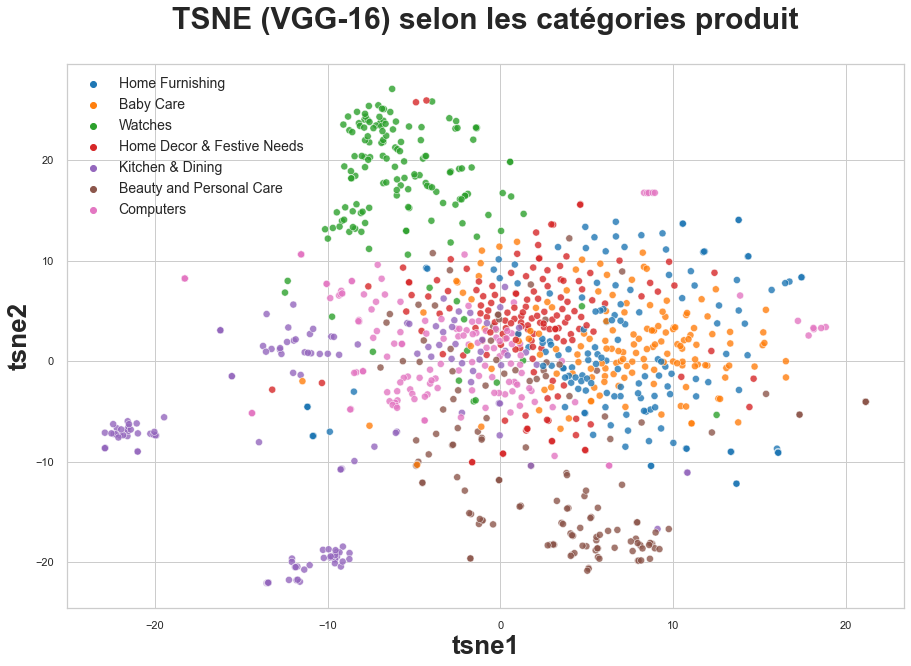

In [113]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_vgg16, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (VGG-16) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

**Observation**

Le regroupement par catégories produits semble meilleur que ce qu'on a pu observer sur les données SIFT.

#### 6.2.3 ÉTAPE 3 - Clustering

In [114]:
#Création de clusters à partir du T-SNE 
X = df_tsne_vgg16[["tsne1","tsne2"]]

cls = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls.fit(X)

df_tsne_vgg16["cluster"] = cls.labels_

sil = silhouette_score(X,cls.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

Le score de silhouette est 0.38242033


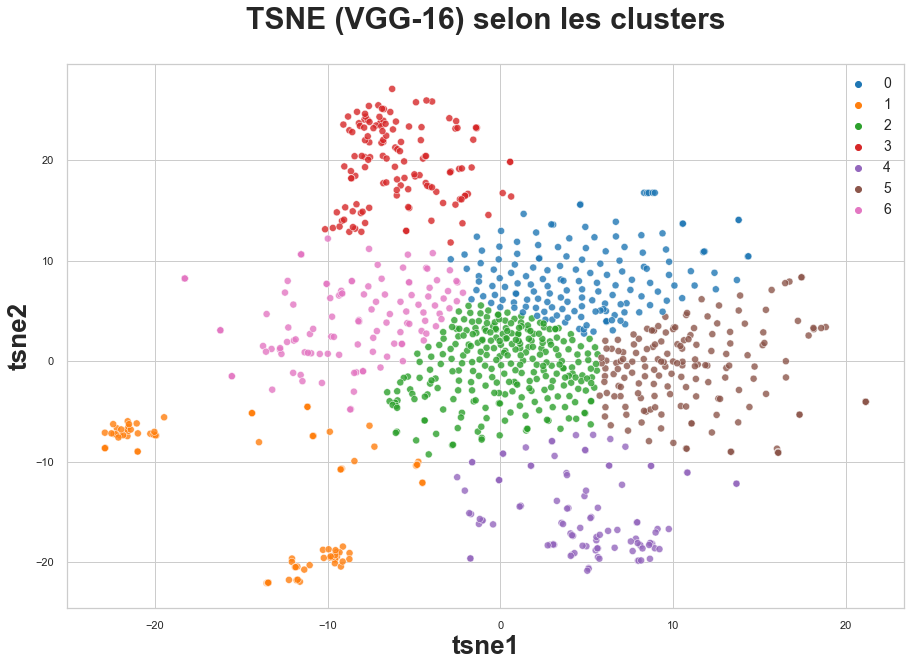

ARI :  0.28182931727228566


In [115]:
#Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_vgg16,
    legend="brief")

plt.title('TSNE (VGG-16) selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = products_image_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

**Observations** 
- le score ARI amélioré (par rapport à celui obtenu sur avec les features SIFT)
- le score de silhouette est egalement amélioré mais reste moins bon que celui obtenu sur les données textes

**Qualité de la catégorisation**

In [116]:
df_tsne_vgg16.groupby("cluster").count()["class"]

cluster
0    156
1     98
2    268
3    131
4    106
5    167
6    124
Name: class, dtype: int64

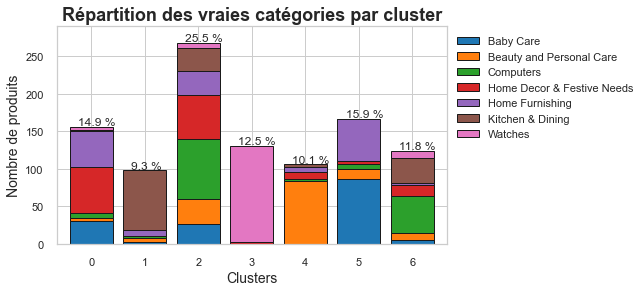

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0              30.0                       4.0        7.0   
1               2.0                       6.0        3.0   
2              26.0                      34.0       80.0   
3               0.0                       0.0        0.0   
4               0.0                      84.0        3.0   
5              87.0                      13.0        7.0   
6               5.0                       9.0       50.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                               62.0             47.0               2.0   
1                                0.0              7.0              80.0   
2                               59.0             32.0              30.0   
3                                2.0              0.0               0.0   
4                                9.0              6.0               4.0   
5                                4.0             55.0               0.0   
6                               14.0              3.0              34.0   

category  Watches  
label              
0             4.0  
1             0.0  
2             7.0  
3           129.0  
4             0.0  
5             1.0  
6             9.0

In [117]:
pf.plot_stacked_bar_clust_vs_cat(df_tsne_vgg16["cluster"],
                              df_tsne_vgg16["class"],
                              df_tsne_vgg16,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,290))

In [118]:
cat_clust_confmat = pf.plot_conf_matrix_cat_vs_clust(df_tsne_vgg16['class'],
                                                  df_tsne_vgg16['cluster'],
                                                  normalize=False,
                                                  margins_sums=True,
                                                  margins_score=True)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(cat_clust_confmat)

cluster                      5   4   6   2   0  1   3 cat_sum  \
class                                                           
Baby Care                   87   0   5  26  30  2   0     150   
Beauty and Personal Care    13  84   9  34   4  6   0     150   
Computers                    7   3  50  80   7  3   0     150   
Home Decor & Festive Needs   4   9  14  59  62  0   2     150   
Home Furnishing             55   6   3  32  47  7   0     150   
Kitchen & Dining             0   4  34  30   2 80   0     150   
Watches                      1   0   9   7   4  0 129     150   
clust_sum                  167 106 124 268 156 98 131       -   
clust_matching_score_pct    52  79  40  22  30 82  98       -   

cluster                    cat_matching_score_pct  
class                                              
Baby Care                                      58  
Beauty and Personal Care                       56  
Computers                                      33  
Home Decor & Festive Needs                     39  
Home Furnishing                                31  
Kitchen & Dining                               53  
Watches                                        86  
clust_sum                                       -  
clust_matching_score_pct                        -

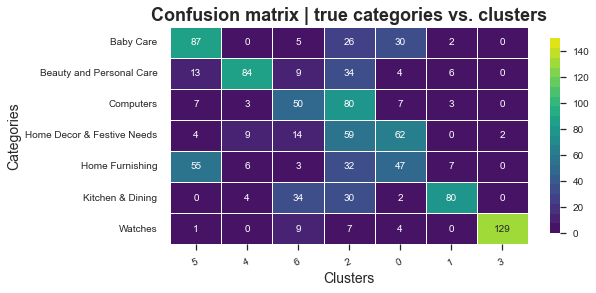

In [119]:
# Affiche la matrice de confusion (Vraies catégories vs. Clusters)

cm = pf.plot_conf_matrix_cat_vs_clust(df_tsne_vgg16['class'],
                            df_tsne_vgg16['cluster'],
                            normalize=False,
                            margins_sums=False,
                            margins_score=False)
pf.plot_heatmap(cm, "Confusion matrix | true categories vs. clusters",
             figsize=(8, 4), vmin=0, vmax=150, center=75,
                 palette=sns.color_palette("viridis", 20), shape='rect',
                 fmt='.0f', robust=False, fig=None, ax=None)

**Observations**

- ARI = 0.28
- Silhouette = 0.38
- 514 erreurs de catégorisation
- On a une meilleure classification des images en utilisation les features obtenus par Tranfer Learning